# **Paysim Fraud Detection**

The aim of this project is to identify fraudulent transactions contained in a synthetic dataset originally presented in the paper:  
 [PAYSIM: A FINANCIAL MOBILE MONEY SIMULATOR FOR FRAUD DETECTION](https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION)  

This dataset is a subset of that dataset and was sourced from [Kaggle](https://www.kaggle.com/datasets/ealaxi/paysim1/data), and has been downscaled to 1/4 of the original dataset.  

# **Ethical considerations**

*  Prior to beginning any analysis, we need to determine if there are any ethical issues that might arise, considering the project at hand.

*  In this instance, we are predicting whether or not a transaction is fraudulent.

*  The project as a whole, does not appear to target anything that might be considered unethical - you would like to prevent all people from having their money stolen (vs just a subgroup).  The data has also been anonymised and simulated, so investigating the outcomes for specific biases will be difficult.

*  I also believe that my analysis will have minimal risk of being adapted and used for nefarious purposes.

Considering this, I believe the analysis can go forward.




---



The dataset contains several columns:  



* **step** : Maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).  
* **type** : The Type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER."
* **amount** : Amount of the transaction in local currency.  
* **nameOrig**  : Customer who started the transaction
* **oldbalanceOrg**  : Initial balance before the transaction.  
* **newbalanceOrig**  : New balance after the transaction.  
* **nameDest**  : Customer who is the recipient of the transaction.  
* **oldbalanceDest** : Initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).  
* **newbalanceDest**  : New balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).  
* **isFraud**  : This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.  
* **isFlaggedFraud**  : The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200 000 in a single transaction.  



*A notable consideration in the analysis, is that transactions which are detected as fraud are cancelled, so for fraud detection the columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used, as per the [dataset source](https://www.kaggle.com/datasets/ealaxi/paysim1/data)*.


---

# **Importing packages**

Something to note is that specific packages used in specific circumstances, might be imported down the line, else they will be noted in the comments

In [31]:
# https://machinelearningmastery.com/step-by-step-guide-to-deploying-machine-learning-models-with-fastapi-and-docker/

In [32]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sklearn
import shap

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from functools import reduce


In [33]:
# Set options for packages imported
sns.set_style('darkgrid')
plt.style.use('seaborn-v0_8-colorblind')
sns.set(font_scale = 1.25)

#The same seed be used for all randomisation
seed = 1234
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

Print versions of major packages used

In [34]:
print("Python version:", sys.version)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("sklearn version:", sklearn.__version__)



Python version: 3.11.10 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:26) [MSC v.1929 64 bit (AMD64)]
pandas version: 2.2.3
seaborn version: 0.13.2
numpy version: 1.26.4
matplotlib version: 3.9.2
sklearn version: 1.5.1


# **Importing the Data**

In [35]:
# Mount the google drive, to allow import of the dataset
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
# import sys
# sys.path.append('/content/drive/MyDrive')

In [37]:
# Import using pandas to read the CSV file
df = pd.read_csv('PS_20174392719_1491204439457_log.csv',\
# defining smaller datatypes (ex int32 vs int64), reduces memory usage in cases where it is not needed
                 dtype={'step': 'int32',
                                         'type':'str',
                                         'amount':"float32",
                                         'nameOrig':"str",
                                         'oldbalanceOrg':"float32",
                                         'newbalanceOrig':"float32",
                                         'nameDest':'str',
                                         'oldbalanceDest':"float32",
                                         'newbalanceDest':"float32",
                                         'isFraud':'int8',
                                         'isFlaggedFraud':'int8'
                                         })

In [38]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0


In [39]:
# Confirm whether datatypes imported correctly
df.dtypes

step                int32
type               object
amount            float32
nameOrig           object
oldbalanceOrg     float32
newbalanceOrig    float32
nameDest           object
oldbalanceDest    float32
newbalanceDest    float32
isFraud              int8
isFlaggedFraud       int8
dtype: object

#### **Anonymisation**
Looking at the data, we can see that it has been anonymized as described in the metadata:

*  There is no clear indication of personal details of customers.

*  An ethical consideration, would have been whether or not you would have the opportunity (albeit inadvertantly) to build a model that discriminates based on age, gender, race or any other factor.  The anonymisation makes this difficult to impossible in this instance.  

*  The anonymisation does eliminate discrimination from a developer perspective, but certain characteristics in the data could still influence it (for instance - what if the particular product under investigation was only marketed in certain areas which has a higher population of certain ethnic groups)


---



# **Exploratory Analysis**

In [40]:
# Get data types of columns to see if the imported correctly
df.dtypes

step                int32
type               object
amount            float32
nameOrig           object
oldbalanceOrg     float32
newbalanceOrig    float32
nameDest           object
oldbalanceDest    float32
newbalanceDest    float32
isFraud              int8
isFlaggedFraud       int8
dtype: object

In [41]:
# Rename the one column to be consistent with others
df = df.rename(columns={"oldbalanceOrg" : "oldbalanceOrig"})

In [17]:
# Dataframe dimensions to get an idea of the scale of the data
print(f"This dataframe has {len(df)} rows and {len(df.columns)} columns.")

This dataframe has 6362620 rows and 11 columns.


In [18]:
# Check summary statistics, sending the result to pandas, to more neatly format it for viewing and comparison
df.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
step,"6,362,620.00",243.40,142.33,1.00,156.00,239.00,335.00,743.00
amount,"6,362,620.00","179,861.92","599,135.75",0.00,"13,389.57","74,871.94","208,721.48","92,445,520.00"
oldbalanceOrig,"6,362,620.00","833,883.38","2,831,752.75",0.00,0.00,"14,208.00","107,315.18","59,585,040.00"
newbalanceOrig,"6,362,620.00","855,113.69","2,862,818.50",0.00,0.00,0.00,"144,258.41","49,585,040.00"
oldbalanceDest,"6,362,620.00","1,100,701.75","3,369,337.50",0.00,0.00,"132,705.66","943,036.69","356,015,904.00"
newbalanceDest,"6,362,620.00","1,224,996.88","3,629,806.50",0.00,0.00,"214,661.45","1,111,909.22","356,179,264.00"
isFraud,"6,362,620.00",0.00,0.04,0.00,0.00,0.00,0.00,1.00
isFlaggedFraud,"6,362,620.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [19]:
df['isFraud'].sum()/len(df)

0.001290820448180152

There appears to be some outlying values for various fields, I would like to investigate how skew the data is as well.

In [20]:
# Look for any missing values in the data
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**No Missing values**, which is great - this means it is not something we need to deal with.

As a first step, I want to add a feature that shows me whether or not a Merchant was part of the transaction, as I would like to use that in my profiling of the data.  This could be important in identifying fraudulent transactions.

*Although this and some other derivations constitute part of **feature engineering** implemented later on, it is something I am doing here, as I already believe it could be an important part of the EDA*.

I create an indicator variable showing whether a merchant was part of the transaction either as the Origin, Destination or either of it.

In [21]:
df['merchOrig'] = (df['nameOrig'].str.strip().str.slice(0,1) == 'M').astype(int)
df['merchDest'] = (df['nameDest'].str.strip().str.slice(0,1) == 'M').astype(int)
df['merchInvolved'] = df[["merchOrig", "merchDest"]].max(axis=1)
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,0,1,1
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0,0,1,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0,0,0,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0,0,1,1


Calculate a measure for the **HOUR** of the day on which the transaction occurred.

Looking at the description of the data, the STEP field is related to the hour of the transaction within the month, so we could get the hour of the day a transaction occurred using this.

Using this information, I add the hour of the day into a feature called "txn_hour".

In [22]:
# Transaction hour
df['txn_hour'] = df['step'] % 24
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,0,1,1,1
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0,0,1,1,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0,0,0,0,1
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0,0,1,1,1


*Wishlist item*:

*All of the transactions occur only over a 1 month period, so getting the day of the month wont be relevant here, although day of the week would be something I would want to look at as well.  I dont believe that will bear fruit in this case, as the data is only for a single month. If the data was available for a period of 6 months, this would definitely be a feature I would include.*

I want to see the distribution of transaction types to get an understanding of how the data looks, over and above the basic stats I looked at previously.

Start by looking at the distribution of transaction types in the data, as that is one of the standout categorical fields in the data:

In [23]:
fig = sns.displot(data=df, x='type', stat='probability', height=10, aspect=1.5,palette = 'colorblind', hue='type')
fig.set_axis_labels('Transaction Type', 'Proportion of Transactions')

* The Majority of the Transactions are PAYMENT (34%) and CASH_OUT (35%) transactions.

* DEBIT transactions are by far the least (~1%).

Considering that, how does this distribution compare to the Fraudulent transaction types that occured?

In [24]:
fig = sns.displot(data=df[df['isFraud'] == 1],
                  x='type', stat='probability', height=10, aspect=1.5, color='orange')
fig.set_axis_labels('Transaction Type', 'Proportion of Fraudulent Transactions')

The _only_ Fraudulent transactions are _Transfer and Cash Out_, with roughly equal amounts of each being made.

With "type" being a categorical variable - I want to see some descriptive statistics around the value of the transactions.

I like to view **percentiles**, as it will also give a quick indication on whether or not there are any outliers present.

In [25]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).transpose().round(2)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
step,6362620.00,243.40,142.33,1.00,9.00,16.00,156.00,239.00,335.00,490.00,681.00,743.00
amount,6362620.00,179861.92,599135.75,0.00,449.47,2224.10,13389.57,74871.94,208721.48,518634.19,1615979.50,92445520.00
oldbalanceOrig,6362620.00,833883.38,2831752.75,0.00,0.00,0.00,0.00,14208.00,107315.18,5823702.10,16027256.35,59585040.00
newbalanceOrig,6362620.00,855113.69,2862818.50,0.00,0.00,0.00,0.00,0.00,144258.41,5980262.37,16176160.39,49585040.00
oldbalanceDest,6362620.00,1100701.75,3369337.50,0.00,0.00,0.00,0.00,132705.66,943036.69,5147229.70,12371819.49,356015904.00
newbalanceDest,6362620.00,1224996.88,3629806.50,0.00,0.00,0.00,0.00,214661.45,1111909.22,5515715.97,13137866.93,356179264.00
isFraud,6362620.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
isFlaggedFraud,6362620.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
merchOrig,6362620.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
merchDest,6362620.00,0.34,0.47,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00


In [26]:
# set some display options to format output
pd.set_option('display.max_rows', 500)
df[['type','amount','oldbalanceOrig','newbalanceOrig','oldbalanceDest','newbalanceDest']].groupby('type').describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).transpose().round(2)



type                      CASH_IN     CASH_OUT        DEBIT     PAYMENT  \
amount         count   1399284.00   2237500.00     41432.00  2151495.00   
               mean     168920.30    176274.00      5483.67    13057.61   
               std      126457.70    175195.75     13318.48    12548.46   
               min           0.04         0.00         0.55        0.02   
               1%         2999.74      3108.00        68.53      176.19   
               5%        14552.34     15266.73       324.67      871.69   
               25%       70510.18     72669.65      1500.18     4383.82   
               50%      143427.71    147072.19      3048.99     9482.19   
               75%      239899.09    246539.48      5479.18    17561.22   
               95%      412005.12    427877.16     14795.35    37835.66   
               99%      550870.86    579654.09     50817.98    59500.11   
               max     1915267.88  10000000.00    569077.50   238637.98   
oldbalanceOrig count   1399284.00   2237500.00     41432.00  2151495.00   
               mean    3590463.00     46023.82     68647.34    68216.81   
               std     5299532.00    177884.12    138442.55   199617.19   
               min           0.00         0.00         0.00        0.00   
               1%            9.00         0.00         0.00        0.00   
               5%          787.00         0.00         0.00        0.00   
               25%       37768.00         0.00      1518.50        0.00   
               50%     1200093.38       556.00     20821.11    10530.00   
               75%     5284254.88     31446.24     68806.61    60883.00   
               95%    15237053.40    229226.76    311319.27   337181.03   
               99%    24397493.60    582650.01    655636.08   690936.66   
               max    38939424.00  43818856.00   4362014.00 43686616.00   
newbalanceOrig count   1399284.00   2237500.00     41432.00  2151495.00   
               mean    3759378.75     17474.19     65161.65    61837.91   
               std     5286442.50    108261.62    137656.69   195175.64   
               min           5.44         0.00         0.00        0.00   
               1%        24033.60         0.00         0.00        0.00   
               5%        69730.51         0.00         0.00        0.00   
               25%      249756.87         0.00         0.00        0.00   
               50%     1369114.94         0.00     16632.42        0.00   
               75%     5450490.38         0.00     62630.80    49654.13   
               95%    15391933.60     94301.90    306820.25   324460.74   
               99%    24554704.80    417293.03    649605.14   676816.24   
               max    38946232.00  43686616.00   4359375.00 43673804.00   
oldbalanceDest count   1399284.00   2237500.00     41432.00  2151495.00   
               mean    1587918.62   1497758.00   1493135.75        0.00   
               std     3712205.25   3633503.25   4386959.50        0.00   
               min           0.00         0.00        85.00        0.00   
               1%            0.00         0.00      6077.05        0.00   
               5%            0.00         0.00     20139.30        0.00   
               25%      161260.77    114685.93    130025.08        0.00   
               50%      547137.31    488098.50    424460.41        0.00   
               75%     1619594.25   1510450.41   1372974.66        0.00   
               95%     6511854.67   6246391.60   6249230.57        0.00   
               99%    13940349.72  13525911.87  13767837.37        0.00   
               max   355553408.00 356015904.00 327827776.00        0.00   
newbalanceDest count   1399284.00   2237500.00     41432.00  2151495.00   
               mean    1467105.25   1691325.50   1513003.50        0.00   
               std     3714345.50   3660743.00   4395709.00        0.00   
               min           0.00         0.00         0.00        0.00   
               1%        

In [27]:
pd.set_option('display.max_rows', 15)

From the above, I can see:

 * TRANSFER and CASH_OUT transactions had the highest _median_ and _Maximum_ transaction values.

* There appears to be **outlying** transaction amounts with all of the transaction types.  This is something I would normally deal with later on, should I want to use a model that is sensitive to outliers.

I would consider *capping* the outliers at the 95th or 99th percentile, or removing the outlying records completely, depending on whether they are found as part of a Fraudulent transaction.   

If the outliers are part of a Fraudulent transaction, I would consider adding a binary variable as well to indicate that it is an Outlying amount, along with capping the amount - this is due to the fact that it is outlying, might be relevant with regards to being Fraudulent

Considering 2 of the features I created (*txn_hour* and *merchInvolved*), how do they relate to the transaction being fraudulent?

In [28]:
ax = sns.catplot(kind='bar',
            data=df.groupby(['txn_hour', 'merchInvolved', 'isFraud'])
                        .size().reset_index()
           , x='txn_hour'
           , y = 0
           , row ='isFraud'
           , hue='merchInvolved'
           , dodge=False
           , height=6
           , aspect=2
           , sharey=False
           ,sharex=False)
ax.set_xlabels('Transaction hour', fontsize=15 )
ax.set_ylabels('Number of transactions', fontsize=15 )

* Between 09:00 and 20:00, there are more transactions that do not involve a merchant, other times merchant transactions start picking up.

* _None of the Fraudulent transactions had a Merchant involved in them, which makes sense as merchants would likely not commit fraud directly on their clients_

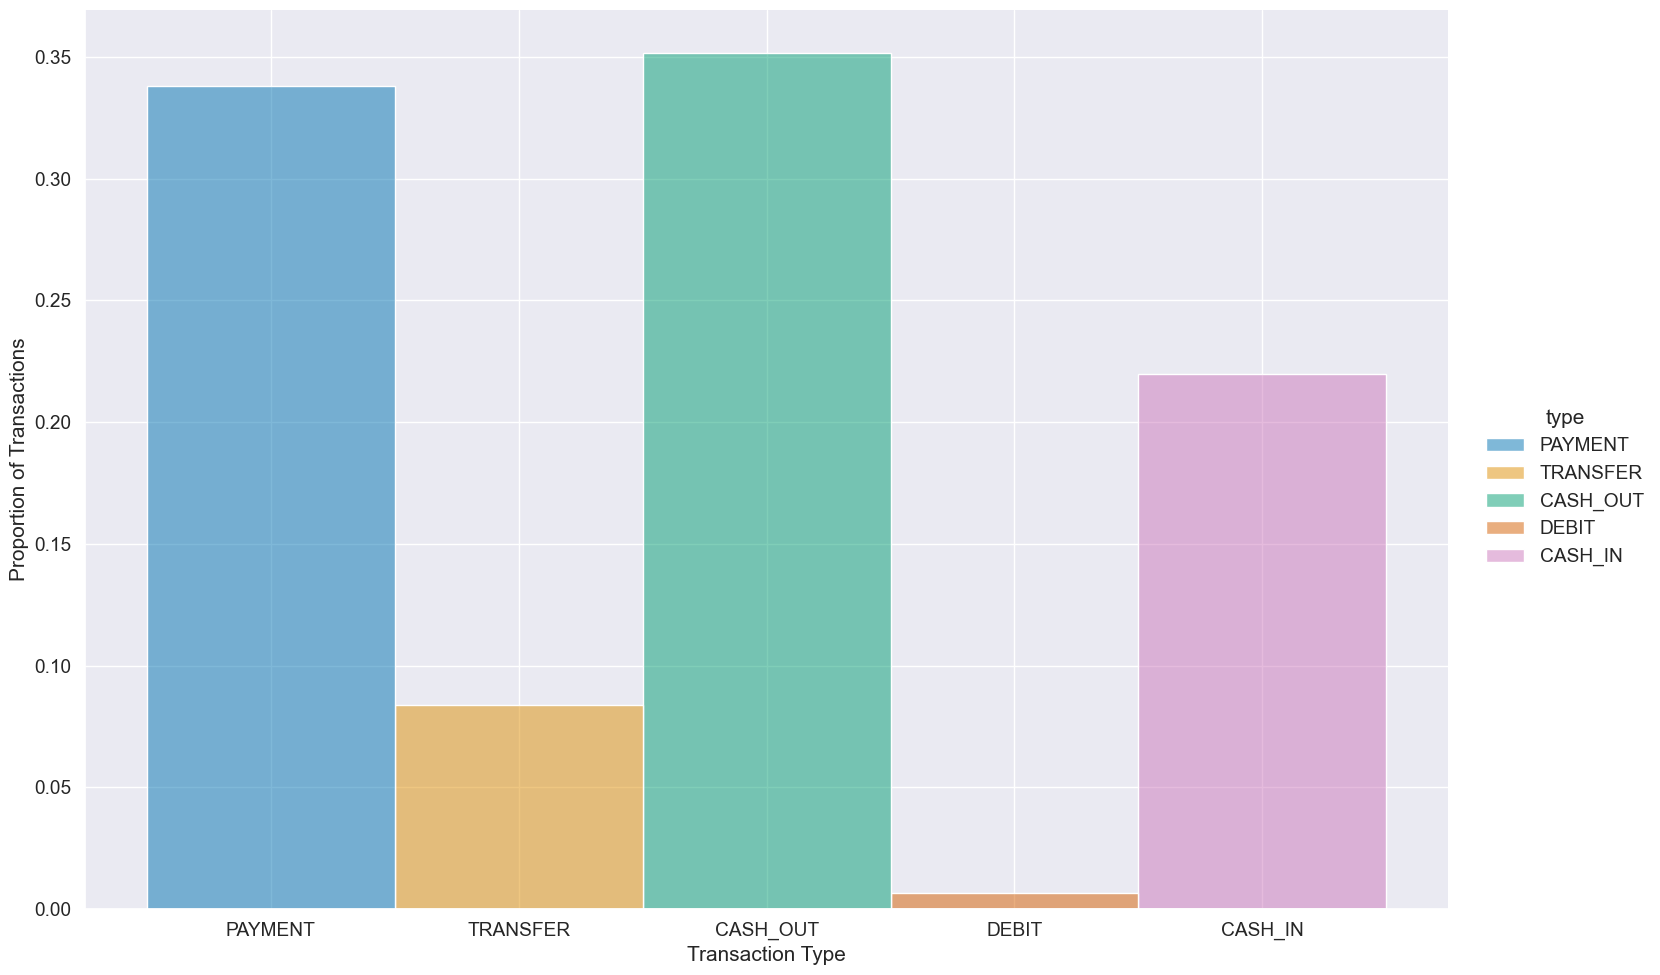

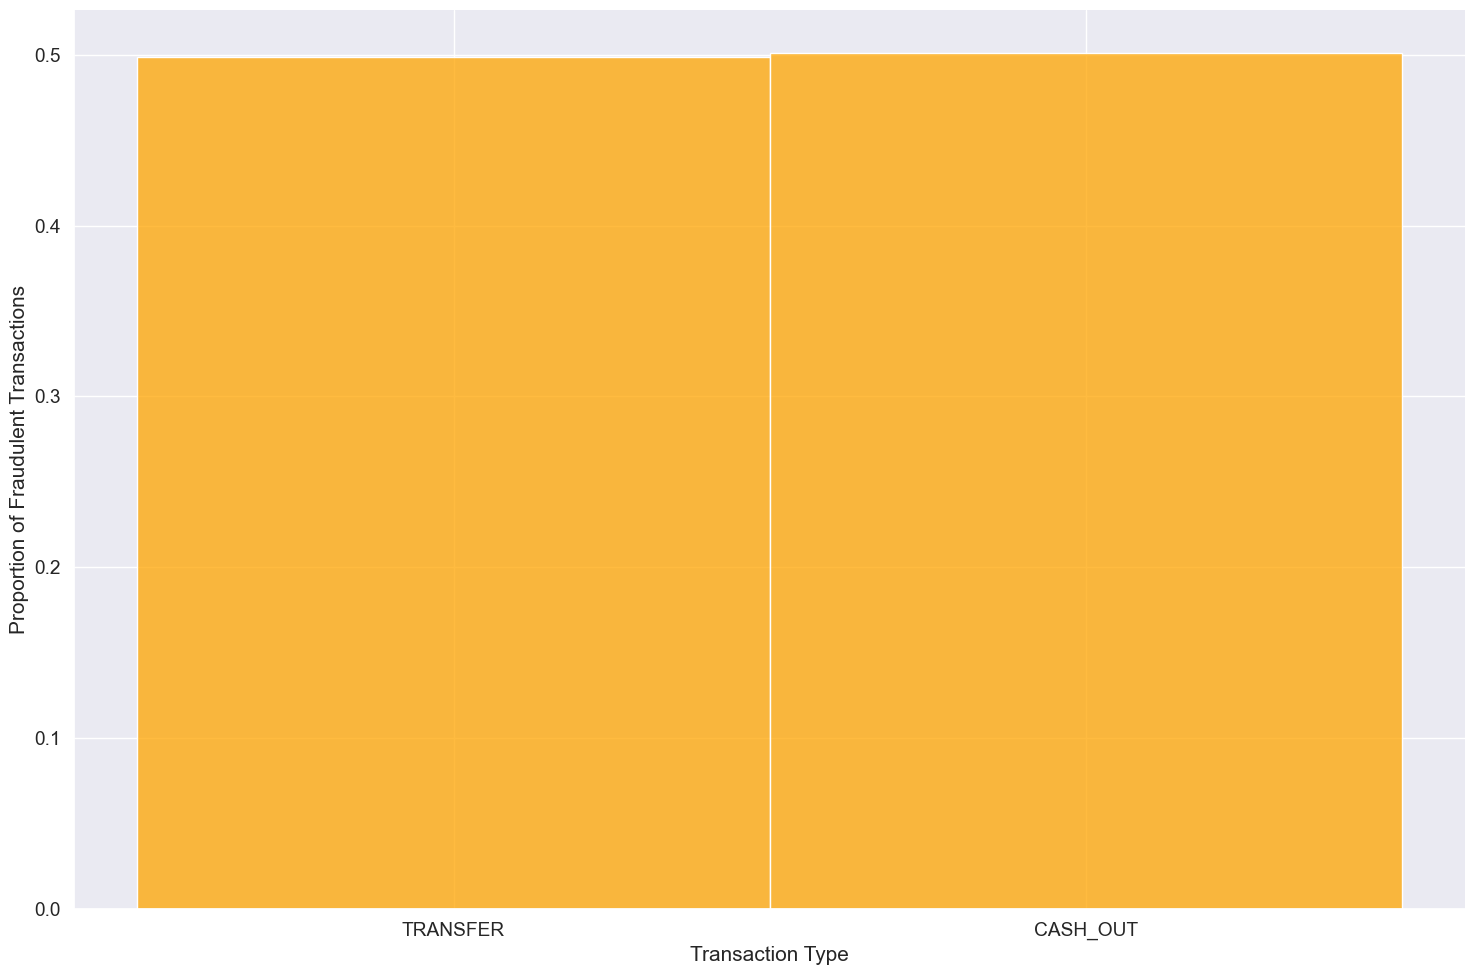

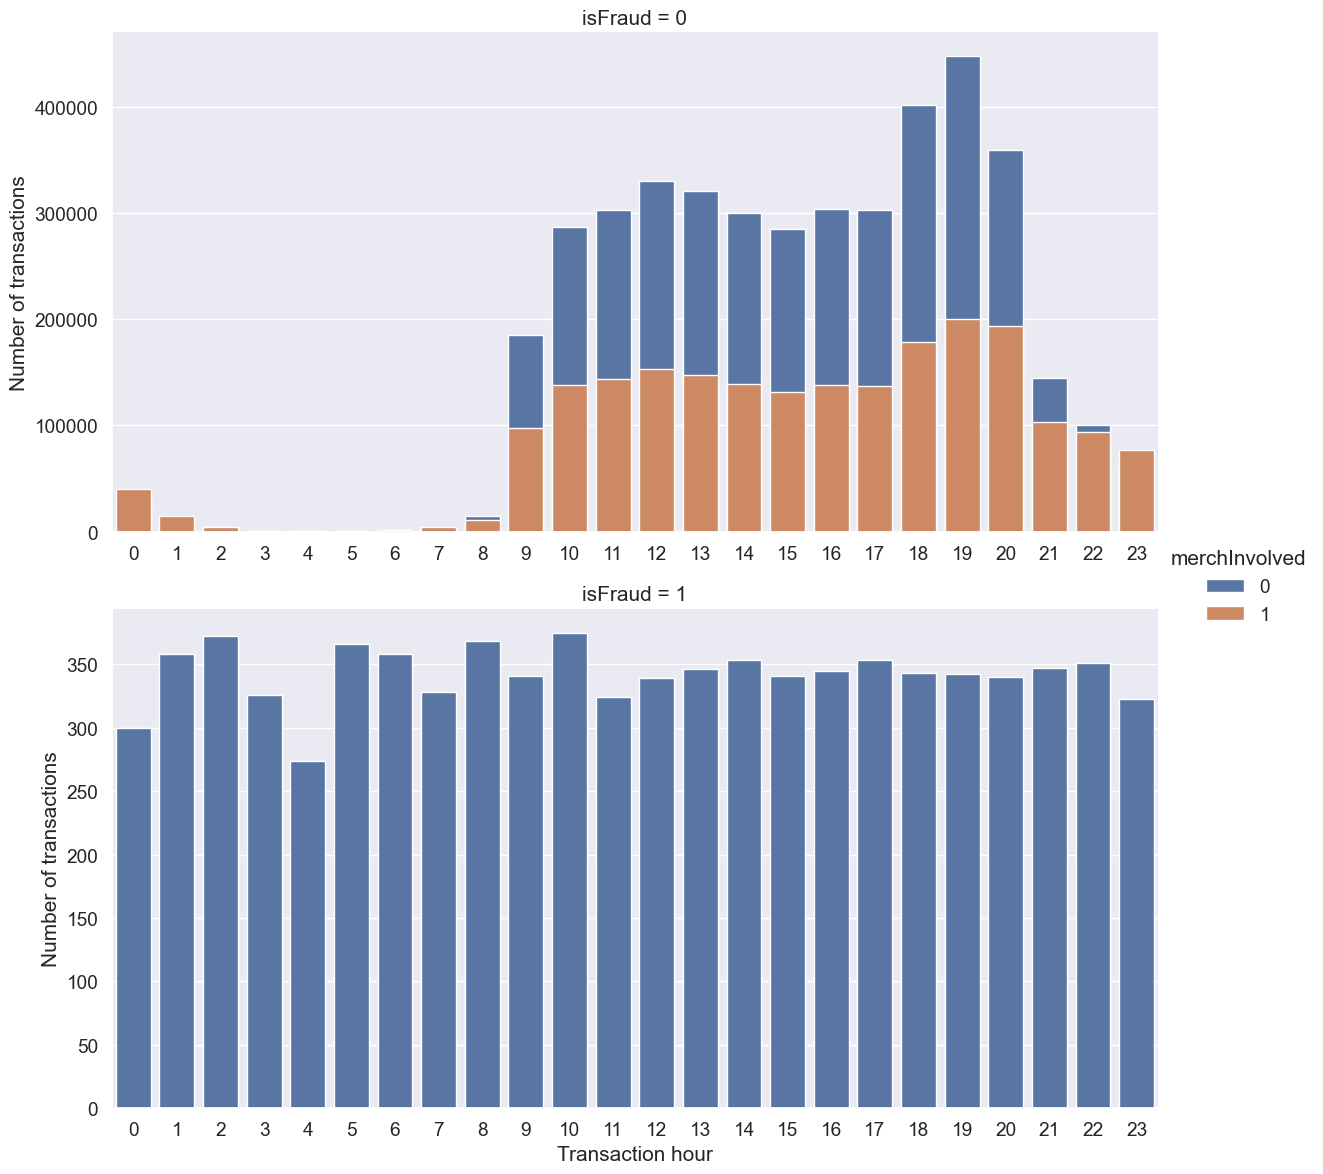

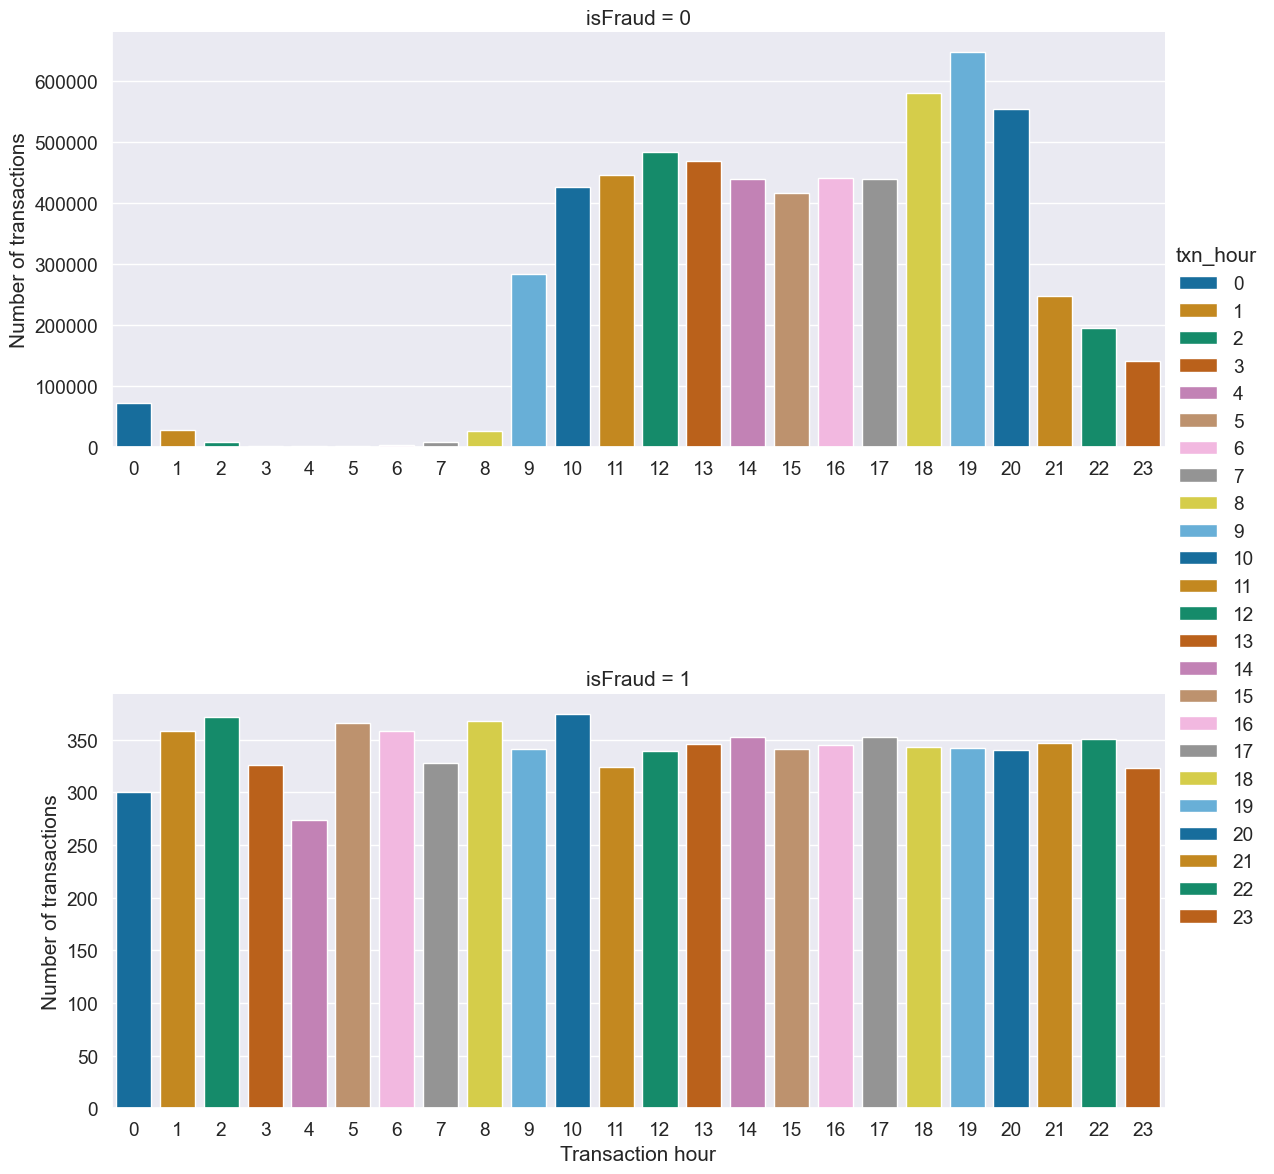

In [29]:
hour_vs_fraud = sns.catplot(  kind  ='count'
            , x     ="txn_hour"
            , row   ='isFraud'
            , data  =df
            , sharey=False
            , height=6
            , aspect=2
            , palette = 'colorblind'
            ,hue= 'txn_hour'
            ,sharex=False
           )
hour_vs_fraud.set_xlabels('Transaction hour')
hour_vs_fraud.set_ylabels('Number of transactions')

plt.show()

* The majority of transactions happen between 09:00 and 19:00 during the day. With some of them after hours.

* Fraudulent transactions are _relatively evenly_ distributed across the day, with no clear peak value.

What does the average transaction amount look like per hour?

In [30]:
# Need to get the average amount per hour and plot that,
# per transaction type and split for fraud vs non-fraud
plt.figure(figsize=(18,6))
sns.lineplot(data=df.groupby(['txn_hour','type'])
                 .agg({'amount' : 'mean'})
                 .reset_index(),
             x='txn_hour',
             y='amount',
             hue='type',
             palette='colorblind'
           )
plt.xlabel('Transaction hour', fontsize=15 )
plt.xticks(range(24), range(24))
plt.ylabel('Avg. transaction amount', fontsize=15)

Text(0, 0.5, 'Avg. transaction amount')

It is a bit hard to see the values for CASH_IN, DEBIT and PAYMENT, due to them being so small compared to the rest, so  I split them out and plot seperately.

In [31]:
# Check for the ones we couldnt make out in the above graph
plt.figure(figsize=(18,6))
sns.lineplot(data=df[df['type']
                        .isin(['DEBIT','PAYMENT'])]
                 .groupby(['txn_hour','type'])
                 .agg({'amount' : 'mean'})
                 .reset_index(),
             x='txn_hour',
             y='amount',
             hue='type',
             palette='colorblind')
plt.xlabel('Transaction hour', fontsize=15 )
plt.xticks(range(24), range(24))
plt.ylabel('Avg. transaction amount', fontsize=15)

Text(0, 0.5, 'Avg. transaction amount')

* CASH OUTS tend to happen early morning (between 03:00 and 05:00), while TRANSFERS peak very early morning (03:00), and again at 16:00

* DEBITS and PAYMENTS peak between 09:00 and 13:00 during the day

What about the parties involved in the transactions? Is there a difference in times throughout the day?

Lets look at the distribution of the various balances for both origination and destination accounts.

In [32]:
bins=15
fig, axs = plt.subplots(3,2,figsize=(20, 20), sharey = False)

axs[0, 0].hist(df['oldbalanceOrig'], bins=bins, color='blue', alpha=0.5, label='oldbalanceOrig', density=True)
axs[0, 0].set_title('oldbalanceOrig')
axs[0, 0].legend()

axs[0, 1].hist(df['newbalanceOrig'], bins=bins, color='blue',
               alpha=0.5, label='newbalanceOrig', density=True)
axs[0, 1].set_title('newbalanceOrig')
axs[0, 1].legend()

axs[1, 0].hist(df['oldbalanceDest'], bins=bins, color='blue', alpha=0.5, label='oldbalanceDest', density=True)
axs[1, 0].set_title('oldbalanceDest')
axs[1, 0].legend()

axs[1, 1].hist(df['newbalanceDest'], bins=bins, color='blue', alpha=0.5, label='newbalanceDest', density=True)
axs[1, 1].set_title('newbalanceDest')
axs[1, 1].legend()

axs[2, 0].hist(df['amount'], bins=bins, color='blue', alpha=0.5, label='amount', density=True)
axs[2, 0].set_title('amount')
axs[2, 0].legend()



* Most of these data points are _very skewed_ as we saw before when looking at the statistics.

It might be better to display the data without the massive skewness I see in there, so I am applying a _log transformation_ on everything I plot.

The data is also split for fraud vs non-fraud transactions to see if there are differences in the distributions between the 2 sets.

In [33]:
# Create a fraud dataframe and a non-fraud dataframe
df_fraud    = df[df['isFraud'] == 1]
df_nonfraud = df[df['isFraud'] == 0]

df_nonfraud.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,1,1
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.00,0.00,0,0,0,1,1,1
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.00,0.00,0,0,0,1,1,1


In [34]:
fig, axs = plt.subplots(3,2,figsize=(20, 30), sharey = False)

axs[0, 0].hist((df_nonfraud['oldbalanceOrig'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[0, 0].hist((df_fraud['oldbalanceOrig'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[0, 0].set_title('oldbalanceOrig')
axs[0, 0].legend()

axs[0, 1].hist((df_nonfraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[0, 1].hist((df_fraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[0, 1].set_title('newbalanceOrig')
axs[0, 1].legend()

axs[1, 0].hist((df_nonfraud['oldbalanceDest'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[1, 0].hist((df_fraud['oldbalanceDest'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[1, 0].set_title('oldbalanceDest')
axs[1, 0].legend()

axs[1, 1].hist((df_nonfraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[1, 1].hist((df_fraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[1, 1].set_title('newbalanceOrig')
axs[1, 1].legend()

axs[2, 0].hist((df_nonfraud['amount'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='amount', density=True)
axs[2, 0].hist((df_fraud['amount'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[2, 0].set_title('amount')
axs[2, 0].legend()


* Amounts are skewed to the right for fraudulent transactions - _fraudulent transactions appear to be of higher value_.

* There are a lot of accounts that had a _0 balance AFTER the transaction occurred_, which indicates that fraudulent transactions tend to clear out the accounts.  A feature capturing this could be valuable, however - the balance features should not be used as per the dataset metadata (however, this is only dubious for transactions that WERE detected as fraud)

Something to examine, would be whether customers have multiple transactions in the data?

Due to it being simulated, it might not be.

In [35]:
# How many unique originating and destination names are there?
# Dataframe dimensions to recap the observation count
print(f"This dataframe has {len(df)} rows. \n")

print("Number of unique nameOrig:", df['nameOrig'].nunique())
print("Number of unique nameDest:", df['nameDest'].nunique())

This dataframe has 6362620 rows. 

Number of unique nameOrig: 6353307
Number of unique nameDest: 2722362


* There appear to be _multiple transactions_ per originating and destination client/merchant.  

Meaning features on what happened PRIOR to a transaction happening for each client can be created.

In [36]:
# How many transactions were there, for originating and destination accounts,
# When there are multiple?
df[['nameOrig', 'type']].groupby(['nameOrig']).count() \
                            .reset_index().sort_values(by='type', ascending=False) \
                            .rename(columns={"type": "count"}).head(10)

,nameOrig,count
213775,C1065307291,3
2575378,C1784010646,3
2964663,C1902386530,3
2735131,C1832548028,3
4857429,C545315117,3
1520460,C1462946854,3
3455282,C2051359467,3
4260723,C363736674,3
3207898,C1976208114,3
1742342,C1530544995,3


In [37]:
df[['nameDest', 'type']].groupby(['nameDest']).count() \
                            .reset_index().sort_values(by='type', ascending=False) \
                            .rename(columns={"type": "count"}).head(10)

,nameDest,count
84652,C1286084959,113
567820,C985934102,109
472721,C665576141,105
320660,C2083562754,102
349730,C248609774,101
174831,C1590550415,101
233498,C1789550256,99
409775,C451111351,99
106929,C1360767589,98
6969,C1023714065,97


* There are definitely clients that had multiple transactions in the data, so _creating features to characterise their behaviour prior to a new transaction, could prove valuable_.

What about fraudulent transactions - are there clients that had multiple linked to them?

In [38]:
df[df['isFraud'] == 1][['nameOrig', 'type']].groupby(['nameOrig']).count() \
                            .reset_index().sort_values(by='type', ascending=False) \
                            .rename(columns={"type": "count"}).head(10)

,nameOrig,count
0,C1000036340,1
5391,C334503836,1
5485,C357089378,1
5484,C356905617,1
5483,C356781229,1
5482,C356706674,1
5481,C356571967,1
5480,C356480504,1
5479,C356205172,1
5478,C356177155,1


In [39]:
df[df['isFraud'] == 1][['nameDest', 'type']].groupby(['nameDest']).count() \
                            .reset_index().sort_values(by='type', ascending=False) \
                            .rename(columns={"type": "count"}).head(10)

,nameDest,count
4244,C2020337583,2
6699,C650699445,2
5937,C475338087,2
6065,C505532836,2
759,C1185292292,2
1607,C1399829166,2
6666,C643624257,2
8041,C967226405,2
1453,C1366192319,2
6670,C644163395,2


* There are instances of Destination clients that had multiple fraudulent transactions linked to them.  


*A business rule one could add to prevent fraudulent transactions in future, could be to perform enhanced due diligence, if funds are transferred to a nameDest, that was previously involved in fraudulent transactions.*


---


---




# **Feature Engineering**

Create an indicator variable to show whether the original balance has been cleared out (all funds were transferred out of the account), along with the amount equalling the full balance in the account, identified during the initial EDA.

In [40]:
df['origBalanceCleared'] = (df['newbalanceOrig'] == 0).astype('int')
df['amount_eq_bal']      = (df['amount'] == df['oldbalanceOrig']).astype('int')
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,1,1,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,1,1,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1,1,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,0,0,1,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,1,1,0,0


Now identify clients' behaviour BEFORE a particular transaction, and whether the client was involved in a fraudulent transaction before.

In [41]:
# Create tables that summarise the features for the
# originating party and the destination party respectively
orig_features = df.merge(df, left_on='nameOrig', right_on='nameOrig', how='left'\
                         , suffixes=('', '_y'))
orig_features = orig_features[orig_features['step_y'] < orig_features['step']]
orig_features.head()


,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,step_y,type_y,amount_y,oldbalanceOrig_y,newbalanceOrig_y,nameDest_y,oldbalanceDest_y,newbalanceDest_y,isFraud_y,isFlaggedFraud_y,merchOrig_y,merchDest_y,merchInvolved_y,txn_hour_y,origBalanceCleared_y,amount_eq_bal_y
115719,11,PAYMENT,17670.78,C1709295811,488136.00,470465.22,M356415752,0.00,0.00,0,0,0,1,1,11,0,0,10,TRANSFER,497725.94,0.00,0.00,C201995133,1033478.62,1531204.62,0,0,0,0,0,10,1,0
147289,12,CASH_IN,127216.34,C44568807,627.00,127843.34,C1768792843,95742.51,0.00,0,0,0,0,0,12,0,0,8,PAYMENT,6107.51,730.00,0.00,M458189677,0.00,0.00,0,0,0,1,1,8,1,0
148940,12,PAYMENT,4611.17,C260230637,228156.00,223544.83,M350428813,0.00,0.00,0,0,0,1,1,12,0,0,9,PAYMENT,12712.93,72799.00,60086.07,M1752517967,0.00,0.00,0,0,0,1,1,9,0,0
196711,13,PAYMENT,2745.21,C745009740,0.00,0.00,M1554169249,0.00,0.00,0,0,0,1,1,13,1,0,10,CASH_OUT,41726.55,0.00,0.00,C1488712549,54115.86,95842.42,0,0,0,0,0,10,1,0
209202,13,CASH_OUT,220681.45,C1842781381,70129.00,0.00,C1619574897,0.00,220681.45,0,0,0,0,0,13,1,0,12,PAYMENT,4231.32,49982.00,45750.68,M172037083,0.00,0.00,0,0,0,1,1,12,0,0


In [42]:
dest_features = df.merge(df, left_on='nameDest', right_on='nameDest', how='left'\
                         , suffixes=('', '_y'))
dest_features = dest_features[dest_features['step_y'] < dest_features['step']]
dest_features.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,step_y,type_y,amount_y,nameOrig_y,oldbalanceOrig_y,newbalanceOrig_y,oldbalanceDest_y,newbalanceDest_y,isFraud_y,isFlaggedFraud_y,merchOrig_y,merchDest_y,merchInvolved_y,txn_hour_y,origBalanceCleared_y,amount_eq_bal_y
88091,2,CASH_IN,171039.05,C265052195,19276.00,190315.05,C662736689,4800393.00,4629354.00,0,0,0,0,0,2,0,0,1,DEBIT,5853.21,C2066892165,5039.00,0.00,20018.00,4891090.50,0,0,0,0,0,1,1,0
88092,2,CASH_IN,171039.05,C265052195,19276.00,190315.05,C662736689,4800393.00,4629354.00,0,0,0,0,0,2,0,0,1,TRANSFER,301298.69,C1520491508,213449.00,0.00,25871.21,4891090.50,0,0,0,0,0,1,1,0
88093,2,CASH_IN,171039.05,C265052195,19276.00,190315.05,C662736689,4800393.00,4629354.00,0,0,0,0,0,2,0,0,1,CASH_IN,72897.92,C1539088279,6666214.50,6739112.50,327169.91,4891090.50,0,0,0,0,0,1,0,0
88094,2,CASH_IN,171039.05,C265052195,19276.00,190315.05,C662736689,4800393.00,4629354.00,0,0,0,0,0,2,0,0,1,CASH_IN,189595.83,C1699486292,7007545.00,7197141.00,254271.98,4891090.50,0,0,0,0,0,1,0,0
88095,2,CASH_IN,171039.05,C265052195,19276.00,190315.05,C662736689,4800393.00,4629354.00,0,0,0,0,0,2,0,0,1,CASH_IN,187256.62,C1106468732,521018.56,521018.56,521018.56,4891090.50,0,0,0,0,0,1,0,0


Examining the data results, it had the effect I wanted, as the table joined to itself, where the current transaction step is smaller than the previous one.

Note that not all clients will have features here, depending on if they transacted before, or not.

I now want to group the features for the destination and the origination features to create the various behavioural features.

I am interested in:

    1. How many merchants that party has transacted with previously (sum(merchInvolved)
    2. How many transactions they made previously (count(PREV_STEP))
    3. What is the average transaction amount they have made previously (avg(amount))
    4. What the average time is that transactions are usually made for them (avg(txn_hour))
    5. Whether they have been involved in Fraud before (max(isFraud))
    6. How many times they have been involved with transactions with Merchants (sum(merchInvolved))
    7. How many times transactions were conducted where a merchant was the orginating or destination party (sum(merchOrig), sum(merchDest))

In [43]:
orig_features = orig_features.groupby(['nameOrig', 'step'])\
                                            .agg({"step_y": "count", "amount_y" :"mean", "isFraud_y" :"max", \
                                              "txn_hour_y": "mean", "merchInvolved_y" : "sum", \
                                              "merchOrig_y" : "sum", "merchDest_y":"sum"}) \
                                            .reset_index()\
                                            .rename(columns={\
                                                     'merchInvolved_y'   :'prev_orig_merchInvolved_total',\
                                                     'isFraud_y'         :'prev_orig_fraud_max',
                                                     'txn_hour_y'        :'prev_orig_txn_hour_avg',
                                                     'merchDest_y'       :'prev_orig_merchDest_sum',
                                                     'amount_y'          :'prev_orig_avg_amount',
                                                     'step_y'            :'prev_orig_steps_num',
                                                     'merchOrig_y'       :'prev_orig_merch_orig_sum'
                                                    })
orig_features.head()

,nameOrig,step,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum
0,C100025963,277,1,21813.13,0,14.00,0,0,0
1,C1000442951,352,1,44373.09,0,15.00,0,0,0
2,C1000947901,285,1,29929.79,0,20.00,0,0,0
3,C1001064466,469,1,49421.26,0,18.00,0,0,0
4,C1001477354,397,1,61925.08,0,19.00,0,0,0


In [44]:
dest_features = dest_features.groupby(['nameDest', 'step'])\
                                            .agg({"step_y": "count", "amount_y" :"mean", "isFraud_y" :"max", \
                                              "txn_hour_y": "mean", "merchInvolved_y" : "sum", \
                                              "merchOrig_y" : "sum", "merchDest_y":"sum"}) \
                                            .reset_index()\
                                            .rename(columns={\
                                                     'merchInvolved_y'   :'prev_dest_merchInvolved_total',\
                                                     'isFraud_y'         :'prev_dest_fraud_max',
                                                     'txn_hour_y'        :'prev_dest_txn_hour_avg',
                                                     'merchDest_y'       :'prev_dest_merchDest_sum',
                                                     'amount_y'          :'prev_dest_avg_amount',
                                                     'step_y'            :'prev_dest_steps_num',
                                                     'merchOrig_y'       :'prev_dest_merch_orig_sum'
                                                    })
dest_features.head()

,nameDest,step,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum
0,C1000004082,354,1,156985.31,0,16.00,0,0,0
1,C1000004082,370,2,192618.81,0,17.00,0,0,0
2,C1000004082,374,3,572326.88,0,14.67,0,0,0
3,C1000004082,379,4,520002.84,0,14.50,0,0,0
4,C1000004082,396,5,447205.44,0,15.40,0,0,0


In [45]:
# join everything together into one dataframe and seeing how it joined, and if it joined correctly
df = pd.merge(df, orig_features, left_on=['nameOrig','step'], \
               right_on =['nameOrig','step'], how='left')

df = pd.merge(df, dest_features, left_on=['nameDest','step'], \
               right_on =['nameDest','step'], how='left')

df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Release some memory from dataframes no longer needed
del orig_features
del dest_features

Owing to the _skewness_ of some of the data, applying a LOG transformation to the numeric columns plotted before could resolve this. To deal with the skewness and create the new features I actually want to model on (although my aim is not to use any modeling techniques that will be significantly influenced by the skewness of the data).

Since some variables have a 0 in them, I take the log + 1 of everything as the log of 0 does not exist.

In [47]:
df['log_oldbalanceOrig'     ]  = np.log1p(df['oldbalanceOrig'      ] )
df['log_newbalanceOrig'      ] = np.log1p(df['newbalanceOrig'      ] )
df['log_oldbalanceDest'      ] = np.log1p(df['oldbalanceDest'      ] )
df['log_newbalanceDest'      ] = np.log1p(df['newbalanceDest'      ] )
df['log_amount'              ] = np.log1p(df['amount'              ] )
df['log_prev_orig_avg_amount'] = np.log1p(df['prev_orig_avg_amount'] )
df['log_prev_dest_avg_amount'] = np.log1p(df['prev_dest_avg_amount'] )

df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,11.98,0.00,0.00,9.19,NaN,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.96,9.87,0.00,0.00,7.53,NaN,NaN
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.20,0.00,0.00,0.00,5.20,NaN,NaN
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.20,0.00,9.96,0.00,5.20,NaN,NaN
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.63,10.31,0.00,0.00,9.36,NaN,NaN


Calculating the difference between general time someone has previously done transactions and the current transaction under investigation (either the originating or destination party) might be valuable, as transactions that happen at a different time than normal for a client, might be fraudulent.

In [48]:
df['hour_diff_orig'] = df['txn_hour'] - df['prev_orig_txn_hour_avg']
df['hour_diff_dest'] = df['txn_hour'] - df['prev_dest_txn_hour_avg']

df[~df['prev_dest_txn_hour_avg'].isnull()].head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest
2721,2,CASH_IN,171039.05,C265052195,19276.00,190315.05,C662736689,4800393.00,4629354.00,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,141266.67,0.00,1.00,0.00,0.00,0.00,9.87,12.16,15.38,15.35,12.05,NaN,11.86,NaN,1.00
2725,2,DEBIT,3167.07,C1176001051,131947.56,128780.50,C1899073220,628145.75,877201.50,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.00,176952.88,0.00,1.00,0.00,0.00,0.00,11.79,11.77,13.35,13.68,8.06,NaN,12.08,NaN,1.00
2740,2,CASH_IN,186660.81,C1282899579,56323.93,242984.75,C503195940,0.00,0.00,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,154160.81,0.00,1.00,0.00,0.00,0.00,10.94,12.40,0.00,0.00,12.14,NaN,11.95,NaN,1.00
2741,2,CASH_IN,168258.14,C1594065480,242984.75,411242.88,C1870252780,7515467.50,7416185.00,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.00,141583.77,0.00,1.00,0.00,0.00,0.00,12.40,12.93,15.83,15.82,12.03,NaN,11.86,NaN,1.00
2742,2,CASH_IN,142236.30,C2028088629,411242.88,553479.19,C1750905143,424250.44,282014.16,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.00,170092.41,0.00,1.00,0.00,0.00,0.00,12.93,13.22,12.96,12.55,11.87,NaN,12.04,NaN,1.00


Also calculate the difference between average transaction amount someone has previously done and the current transaction under investigation (either the originating or destination party).

In [49]:
df['amt_diff_orig'] = df['amount'] - df['prev_orig_avg_amount']
df['amt_diff_dest'] = df['amount'] - df['prev_dest_avg_amount']
df[~df['amt_diff_dest'].isnull()].head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest
2721,2,CASH_IN,171039.05,C265052195,19276.00,190315.05,C662736689,4800393.00,4629354.00,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,141266.67,0.00,1.00,0.00,0.00,0.00,9.87,12.16,15.38,15.35,12.05,NaN,11.86,NaN,1.00,NaN,29772.38
2725,2,DEBIT,3167.07,C1176001051,131947.56,128780.50,C1899073220,628145.75,877201.50,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.00,176952.88,0.00,1.00,0.00,0.00,0.00,11.79,11.77,13.35,13.68,8.06,NaN,12.08,NaN,1.00,NaN,-173785.81
2740,2,CASH_IN,186660.81,C1282899579,56323.93,242984.75,C503195940,0.00,0.00,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,154160.81,0.00,1.00,0.00,0.00,0.00,10.94,12.40,0.00,0.00,12.14,NaN,11.95,NaN,1.00,NaN,32500.00
2741,2,CASH_IN,168258.14,C1594065480,242984.75,411242.88,C1870252780,7515467.50,7416185.00,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.00,141583.77,0.00,1.00,0.00,0.00,0.00,12.40,12.93,15.83,15.82,12.03,NaN,11.86,NaN,1.00,NaN,26674.38
2742,2,CASH_IN,142236.30,C2028088629,411242.88,553479.19,C1750905143,424250.44,282014.16,0,0,0,0,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.00,170092.41,0.00,1.00,0.00,0.00,0.00,12.93,13.22,12.96,12.55,11.87,NaN,12.04,NaN,1.00,NaN,-27856.11




---



## Training and test data split

Although there is still some feature engineering to happen, the split between Training and Testing set is happening now to prevent any data leakage occuring between the training and test dataset.

In [50]:
# train, test = df.randomSplit([0.8, 0.2], seed=seed)
train, test = train_test_split(df, random_state=123, test_size = 0.2)

In [51]:
print("train shape", train.shape)
print("test shape" , test.shape)

train shape (5090096, 42)
test shape (1272524, 42)


Some of the new features that were created have some missing values in it due to the clients, for example, never having done transactions before.

In this instance, the decision was made to NOT impute them with anything other than a 0, as there is no plan on using any models that are sensitive to missing values.  The implication of making it a 0 here, is that the transaction never happened, but could have.  In this instance, these two scenarios are considered as being the same thing.

However - imputing some values with 0 and some with the average, depending on the context of the specific feature, or added an indicator of whether a value was 0 initially, or only after imputation could also be done to retain information on the imputation.

In [52]:
# Define the imputation using the SimpleImputer
imputer =  SimpleImputer(missing_values=np.nan, strategy='constant', add_indicator = True, fill_value = 0)

In [53]:
# apply imputation and return the dataframe
train = pd.DataFrame(imputer.fit_transform(train), columns = imputer.get_feature_names_out())
test  = pd.DataFrame(imputer.transform(test)     , columns = imputer.get_feature_names_out())

Considering that we have some _categorical_ variables in the data, I want to convert this to numerical features.

Thus, I need to create some one-hot encoded variables for the transaction types, using a OneHotEncoder.

The main features we are looking to convert to numerical, is the transaction type and the tranaction hour in which the transaction happened.

In [54]:
# Define columns to be One-hot encoded
cat_cols = ['txn_hour', 'type']

In [55]:
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

In [56]:
train_ohe = ohe.fit_transform(train[cat_cols])

In [57]:
train_ohe_df =  pd.DataFrame(train_ohe, columns=ohe.get_feature_names_out())
train = pd.concat([train, train_ohe_df], axis=1)
train.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,157,PAYMENT,5530.25,C657793176,0.00,0.00,M739568006,0.00,0.00,0,0,0,1,1,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,8.62,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,260,CASH_OUT,110352.76,C1412043435,0.00,0.00,C41698878,2574547.00,2684899.75,0,0,0,0,0,20,1,0,0,0,0,0,0,0,0,14.00,300834.84,0.00,15.36,0.00,0.00,0.00,0.00,0.00,14.76,14.80,11.61,0,12.61,0,4.64,0,-190482.09,True,True,True,True,True,True,True,False,False,False,False,False,False,False,True,False,True,False,True,False,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,44,PAYMENT,5406.11,C450614947,81630.00,76223.89,M691104477,0.00,0.00,0,0,0,1,1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.31,11.24,0.00,0.00,8.60,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,350,PAYMENT,8221.22,C1796508227,3697.00,0.00,M1692201305,0.00,0.00,0,0,0,1,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.22,0.00,0.00,0.00,9.01,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,238,PAYMENT,7787.64,C381041925,82938.00,75150.36,M382945339,0.00,0.00,0,0,0,1,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.33,11.23,0.00,0.00,8.96,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [58]:
test_ohe = ohe.transform(test[cat_cols])
test_ohe_df =  pd.DataFrame(test_ohe, columns=ohe.get_feature_names_out())
test = pd.concat([test, test_ohe_df], axis=1)
test.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,356,PAYMENT,17751.49,C242307473,0.00,0.00,M119567302,0.00,0.00,0,0,0,1,1,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,9.78,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,207,TRANSFER,152335.31,C179777096,63411.56,0.00,C64888758,232513.16,384848.47,0,0,0,0,0,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.06,0.00,12.36,12.86,11.93,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,355,PAYMENT,21345.67,C1850294050,0.00,0.00,M1117931953,0.00,0.00,0,0,0,1,1,19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,9.97,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,305,PAYMENT,56506.15,C1638970953,19318.00,0.00,M1433114714,0.00,0.00,0,0,0,1,1,17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.87,0.00,0.00,0.00,10.94,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,15,PAYMENT,5057.36,C1252008178,12742.99,7685.63,M972740308,0.00,0.00,0,0,0,1,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.45,8.95,0.00,0.00,8.53,0,0,0,0,0,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [59]:
# free up memory
del train_ohe_df
del test_ohe_df

Convert all the imputed indicator values to binary indicator values

In [60]:
for col in train.columns:
    if col[:7] == 'missing':
        train[col] = train[col].astype('int')
        test[col] = test[col].astype('int')
train.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,157,PAYMENT,5530.25,C657793176,0.00,0.00,M739568006,0.00,0.00,0,0,0,1,1,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,8.62,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,260,CASH_OUT,110352.76,C1412043435,0.00,0.00,C41698878,2574547.00,2684899.75,0,0,0,0,0,20,1,0,0,0,0,0,0,0,0,14.00,300834.84,0.00,15.36,0.00,0.00,0.00,0.00,0.00,14.76,14.80,11.61,0,12.61,0,4.64,0,-190482.09,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,44,PAYMENT,5406.11,C450614947,81630.00,76223.89,M691104477,0.00,0.00,0,0,0,1,1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.31,11.24,0.00,0.00,8.60,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,350,PAYMENT,8221.22,C1796508227,3697.00,0.00,M1692201305,0.00,0.00,0,0,0,1,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.22,0.00,0.00,0.00,9.01,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,238,PAYMENT,7787.64,C381041925,82938.00,75150.36,M382945339,0.00,0.00,0,0,0,1,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.33,11.23,0.00,0.00,8.96,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


Also convert the one hot encoded values to integer

In [61]:
for col in train.columns:
    if col[:5] == 'type_':
        train[col] = train[col].astype('int16')
        test[col] = test[col].astype('int16')
train.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,157,PAYMENT,5530.25,C657793176,0.00,0.00,M739568006,0.00,0.00,0,0,0,1,1,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,8.62,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0
1,260,CASH_OUT,110352.76,C1412043435,0.00,0.00,C41698878,2574547.00,2684899.75,0,0,0,0,0,20,1,0,0,0,0,0,0,0,0,14.00,300834.84,0.00,15.36,0.00,0.00,0.00,0.00,0.00,14.76,14.80,11.61,0,12.61,0,4.64,0,-190482.09,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1,0,0,0
2,44,PAYMENT,5406.11,C450614947,81630.00,76223.89,M691104477,0.00,0.00,0,0,0,1,1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.31,11.24,0.00,0.00,8.60,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0,0,1,0
3,350,PAYMENT,8221.22,C1796508227,3697.00,0.00,M1692201305,0.00,0.00,0,0,0,1,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.22,0.00,0.00,0.00,9.01,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0
4,238,PAYMENT,7787.64,C381041925,82938.00,75150.36,M382945339,0.00,0.00,0,0,0,1,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.33,11.23,0.00,0.00,8.96,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0,0,1,0


In [62]:
for col in train.columns:
    if col[:5] == 'txn_hour_':
        train[col] = train[col].astype('int16')
        test[col] = test[col].astype('int16')
train.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,157,PAYMENT,5530.25,C657793176,0.00,0.00,M739568006,0.00,0.00,0,0,0,1,1,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,8.62,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0
1,260,CASH_OUT,110352.76,C1412043435,0.00,0.00,C41698878,2574547.00,2684899.75,0,0,0,0,0,20,1,0,0,0,0,0,0,0,0,14.00,300834.84,0.00,15.36,0.00,0.00,0.00,0.00,0.00,14.76,14.80,11.61,0,12.61,0,4.64,0,-190482.09,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1,0,0,0
2,44,PAYMENT,5406.11,C450614947,81630.00,76223.89,M691104477,0.00,0.00,0,0,0,1,1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.31,11.24,0.00,0.00,8.60,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0,0,1,0
3,350,PAYMENT,8221.22,C1796508227,3697.00,0.00,M1692201305,0.00,0.00,0,0,0,1,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.22,0.00,0.00,0.00,9.01,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0
4,238,PAYMENT,7787.64,C381041925,82938.00,75150.36,M382945339,0.00,0.00,0,0,0,1,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.33,11.23,0.00,0.00,8.96,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0,0,1,0


In [63]:
# drop unnecessary columns
train.drop(['type', 'txn_hour'], inplace=True, axis=1)
test.drop(['type', 'txn_hour'], inplace=True,axis=1)

Generate list of columns to Model

In [64]:
all_columns = [col for col in train.columns if col not in ['step' ]]
print(all_columns)

['amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'merchOrig', 'merchDest', 'merchInvolved', 'origBalanceCleared', 'amount_eq_bal', 'prev_orig_steps_num', 'prev_orig_avg_amount', 'prev_orig_fraud_max', 'prev_orig_txn_hour_avg', 'prev_orig_merchInvolved_total', 'prev_orig_merch_orig_sum', 'prev_orig_merchDest_sum', 'prev_dest_steps_num', 'prev_dest_avg_amount', 'prev_dest_fraud_max', 'prev_dest_txn_hour_avg', 'prev_dest_merchInvolved_total', 'prev_dest_merch_orig_sum', 'prev_dest_merchDest_sum', 'log_oldbalanceOrig', 'log_newbalanceOrig', 'log_oldbalanceDest', 'log_newbalanceDest', 'log_amount', 'log_prev_orig_avg_amount', 'log_prev_dest_avg_amount', 'hour_diff_orig', 'hour_diff_dest', 'amt_diff_orig', 'amt_diff_dest', 'missingindicator_prev_orig_steps_num', 'missingindicator_prev_orig_avg_amount', 'missingindicator_prev_orig_fraud_max', 'missingindicator_prev_orig_txn_hour_avg', 'missingindicator_prev

In [65]:
# Export data to csv to save it and clear some memory, prior to modeling
train.to_csv('paysim_train.csv')
test.to_csv('paysim_test.csv')

In [66]:
# free up memory
del train
del test



---



---



# **Model the Data**

The data is now in a state where I would like to start modelling it to predict fraudulent transactions.

Import the packages related to model building and evaluation

In [11]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import time
import os
import pickle

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc,roc_auc_score, average_precision_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.metrics import make_scorer, average_precision_score # Example metrics (if ground truth is available)
from helper_functions import Classification_eval, eval_metrics

from matplotlib.offsetbox import AnchoredText

seed = 1234
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

Import training and testing dataset

In [ ]:
schema = {'Unnamed: 0':'int32',
'step':'int32',
'amount':'float32',
'nameOrig':'object',
'oldbalanceOrig':'float32',
'newbalanceOrig':'float32',
'nameDest':'object',
'oldbalanceDest':'float32',
'newbalanceDest':'float32',
'isFraud':'int32',
'isFlaggedFraud':'int32',
'merchOrig':'int32',
'merchDest':'int32',
'merchInvolved':'int32',
'origBalanceCleared':'int32',
'amount_eq_bal':'int32',
'prev_orig_steps_num':'float32',
'prev_orig_avg_amount':'float32',
'prev_orig_fraud_max':'float32',
'prev_orig_txn_hour_avg':'float32',
'prev_orig_merchInvolved_total':'float32',
'prev_orig_merch_orig_sum':'float32',
'prev_orig_merchDest_sum':'float32',
'prev_dest_steps_num':'float32',
'prev_dest_avg_amount':'float32',
'prev_dest_fraud_max':'float32',
'prev_dest_txn_hour_avg':'float32',
'prev_dest_merchInvolved_total':'float32',
'prev_dest_merch_orig_sum':'float32',
'prev_dest_merchDest_sum':'float32',
'log_oldbalanceOrig':'float32',
'log_newbalanceOrig':'float32',
'log_oldbalanceDest':'float32',
'log_newbalanceDest':'float32',
'log_amount':'float32',
'log_prev_orig_avg_amount':'float32',
'log_prev_dest_avg_amount':'float32',
'hour_diff_orig':'int32',
'hour_diff_dest':'int32',
'amt_diff_orig':'float32',
'amt_diff_dest':'float32',
'missingindicator_prev_orig_steps_num':'int32',
'missingindicator_prev_orig_avg_amount':'int32',
'missingindicator_prev_orig_fraud_max':'int32',
'missingindicator_prev_orig_txn_hour_avg':'int32',
'missingindicator_prev_orig_merchInvolved_total':'int32',
'missingindicator_prev_orig_merch_orig_sum':'int32',
'missingindicator_prev_orig_merchDest_sum':'int32',
'missingindicator_prev_dest_steps_num':'int32',
'missingindicator_prev_dest_avg_amount':'int32',
'missingindicator_prev_dest_fraud_max':'int32',
'missingindicator_prev_dest_txn_hour_avg':'int32',
'missingindicator_prev_dest_merchInvolved_total':'int32',
'missingindicator_prev_dest_merch_orig_sum':'int32',
'missingindicator_prev_dest_merchDest_sum':'int32',
'missingindicator_log_prev_orig_avg_amount':'int32',
'missingindicator_log_prev_dest_avg_amount':'int32',
'missingindicator_hour_diff_orig':'int32',
'missingindicator_hour_diff_dest':'int32',
'missingindicator_amt_diff_orig':'int32',
'missingindicator_amt_diff_dest':'int32',
'txn_hour_1':'int32',
'txn_hour_2':'int32',
'txn_hour_3':'int32',
'txn_hour_4':'int32',
'txn_hour_5':'int32',
'txn_hour_6':'int32',
'txn_hour_7':'int32',
'txn_hour_8':'int32',
'txn_hour_9':'int32',
'txn_hour_10':'int32',
'txn_hour_11':'int32',
'txn_hour_12':'int32',
'txn_hour_13':'int32',
'txn_hour_14':'int32',
'txn_hour_15':'int32',
'txn_hour_16':'int32',
'txn_hour_17':'int32',
'txn_hour_18':'int32',
'txn_hour_19':'int32',
'txn_hour_20':'int32',
'txn_hour_21':'int32',
'txn_hour_22':'int32',
'txn_hour_23':'int32',
'type_CASH_OUT':'int32',
'type_DEBIT':'int32',
'type_PAYMENT':'int32',
'type_TRANSFER':'int32'
}

In [3]:
train = pd.read_csv('paysim_train.csv')
test = pd.read_csv('paysim_test.csv')

In [4]:
# Convert the datatypes according to the schema, to enable less resource usage
train = train.astype(schema)
test = test.astype(schema)

train.head()

,Unnamed: 0,step,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,origBalanceCleared,amount_eq_bal,prev_orig_steps_num,prev_orig_avg_amount,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchInvolved_total,prev_orig_merch_orig_sum,prev_orig_merchDest_sum,prev_dest_steps_num,prev_dest_avg_amount,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchInvolved_total,prev_dest_merch_orig_sum,prev_dest_merchDest_sum,log_oldbalanceOrig,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,missingindicator_prev_orig_steps_num,missingindicator_prev_orig_avg_amount,missingindicator_prev_orig_fraud_max,missingindicator_prev_orig_txn_hour_avg,missingindicator_prev_orig_merchInvolved_total,missingindicator_prev_orig_merch_orig_sum,missingindicator_prev_orig_merchDest_sum,missingindicator_prev_dest_steps_num,missingindicator_prev_dest_avg_amount,missingindicator_prev_dest_fraud_max,missingindicator_prev_dest_txn_hour_avg,missingindicator_prev_dest_merchInvolved_total,missingindicator_prev_dest_merch_orig_sum,missingindicator_prev_dest_merchDest_sum,missingindicator_log_prev_orig_avg_amount,missingindicator_log_prev_dest_avg_amount,missingindicator_hour_diff_orig,missingindicator_hour_diff_dest,missingindicator_amt_diff_orig,missingindicator_amt_diff_dest,txn_hour_1,txn_hour_2,txn_hour_3,txn_hour_4,txn_hour_5,txn_hour_6,txn_hour_7,txn_hour_8,txn_hour_9,txn_hour_10,txn_hour_11,txn_hour_12,txn_hour_13,txn_hour_14,txn_hour_15,txn_hour_16,txn_hour_17,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,157,"5,530.25",C657793176,0.00,0.00,M739568006,0.00,0.00,0,0,0,1,1,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.62,0.00,0.00,0,0,0.00,0.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,260,"110,352.76",C1412043435,0.00,0.00,C41698878,"2,574,547.00","2,684,899.75",0,0,0,0,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00,"300,834.84",0.00,15.36,0.00,0.00,0.00,0.00,0.00,14.76,14.80,11.61,0.00,12.61,0,4,0.00,"-190,482.09",1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,2,44,"5,406.11",C450614947,"81,630.00","76,223.89",M691104477,0.00,0.00,0,0,0,1,1,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.31,11.24,0.00,0.00,8.60,0.00,0.00,0,0,0.00,0.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,3,350,"8,221.22",C1796508227,"3,697.00",0.00,M1692201305,0.00,0.00,0,0,0,1,1,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.22,0.00,0.00,0.00,9.01,0.00,0.00,0,0,0.00,0.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,238,"7,787.64",C381041925,"82,938.00","75,150.36",M382945339,0.00,0.00,0,0,0,1,1,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.33,11.23,0.00,0.00,8.96,0.00,0.00,0,0,0.00,0.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [5]:
# Define columns to model on
all_columns_fit = [col for col in train.columns if col not in ['step',
                                                               'isFraud', 'isFlaggedFraud', 'nameOrig',
                                                               'nameDest', 'Unnamed: 0'
                                                               ,'amount'
                                                               ,'oldbalanceOrig',
                                                                'newbalanceOrig',
                                                                'oldbalanceDest',
                                                                'newbalanceDest'
                                                                ,'prev_orig_avg_amount'
                                                                ,'prev_dest_avg_amount',

              # The balance features are not appropriate to perform supervised modeling on, since there are
#              issues when they were flagged as being fraudulent
                                                                'origBalanceCleared',
                                                                'log_oldbalanceOrig',
                                                                'log_newbalanceOrig',
                                                                'log_oldbalanceDest',
                                                                'log_newbalanceDest',
                                                                'amount_eq_bal'
                                                                ]]
all_columns_fit

['merchOrig',
 'merchDest',
 'merchInvolved',
 'prev_orig_steps_num',
 'prev_orig_fraud_max',
 'prev_orig_txn_hour_avg',
 'prev_orig_merchInvolved_total',
 'prev_orig_merch_orig_sum',
 'prev_orig_merchDest_sum',
 'prev_dest_steps_num',
 'prev_dest_fraud_max',
 'prev_dest_txn_hour_avg',
 'prev_dest_merchInvolved_total',
 'prev_dest_merch_orig_sum',
 'prev_dest_merchDest_sum',
 'log_amount',
 'log_prev_orig_avg_amount',
 'log_prev_dest_avg_amount',
 'hour_diff_orig',
 'hour_diff_dest',
 'amt_diff_orig',
 'amt_diff_dest',
 'missingindicator_prev_orig_steps_num',
 'missingindicator_prev_orig_avg_amount',
 'missingindicator_prev_orig_fraud_max',
 'missingindicator_prev_orig_txn_hour_avg',
 'missingindicator_prev_orig_merchInvolved_total',
 'missingindicator_prev_orig_merch_orig_sum',
 'missingindicator_prev_orig_merchDest_sum',
 'missingindicator_prev_dest_steps_num',
 'missingindicator_prev_dest_avg_amount',
 'missingindicator_prev_dest_fraud_max',
 'missingindicator_prev_dest_txn_hour_avg

In [13]:
scale = len(train['isFraud']) / (train['isFraud'].sum())

# Define hyperparamaters to search
# I cast a wide net on the hyperparamaters, since I am using Randomized search
# Define the parameter grid to search
# param_dist = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [ 4, 5, 6, 7, 8],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'gamma': [0,0.05,  0.1, 0.2],
#     'min_child_weight': [1, 2, 3, 4, 5]
# }

# Reduced grid
# param_dist = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [ 3, 7, 8],
#     'learning_rate': [ 0.1],
#     'subsample': [0.8],
#     'colsample_bytree': [ 0.7],
#     'gamma': [ 0.1, 0.3],
#     'min_child_weight': [ 2, 3, 5]
# }
# Optimum grid
param_dist = {
    'n_estimators': [ 500],
    'max_depth': [  7],
    'learning_rate': [ 0.1],
    'subsample': [0.8],
    'colsample_bytree': [ 0.7],
    'gamma': [ 0.1],
    'min_child_weight': [  5]
}


# create the xgboost classifier
xgb_clf = xgb.XGBClassifier(
                            random_state =seed,
                            objective='binary:logistic',
                            scale_pos_weight=scale
                            )

# Setup the RandomizedSearchCV
# randomized search is conducted, to reduce compute resources, although a full grid search
# will return the best results within the search space
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings sampled
    scoring='average_precision',  # Metric used for evaluation, since it is a very imbalanced set, we use the AUPRC
    cv=3,  # Number of cross-validation folds
    verbose=3,
    random_state=seed,
    n_jobs=4
)


In [14]:
# train the randomized grid search
# %%time
random_search_fit = random_search.fit(train[all_columns_fit], train['isFraud'])

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


View the best parameters selected

In [15]:
print("The best score identified is: ", random_search_fit.best_score_)
print("The best parameters identified are: \n" ,random_search_fit.best_params_)

The best score identified is:  0.4378126174000822
The best parameters identified are: 
 {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}


From the selected hyperparamaters, we can see that the following hyperparameters were selected at the boundary of the search area provided.  This could indicate that a local optimum was reached, vs a global one, especially in a GridSearch scenario, vs a Randomized search.

* n_estimators: 500.
* min_child_weight: 5.

In an ideal scenario, a new parameter distribution would be considered as per below, in an attempt to get closer to global optimums (along with using an exhaustive Grid Search and not a Randomized search).  The paramater distribution could be adjusted as below based on the values selected before, allowing for search around the optima that were selected.

However, the author notes that this might still not yield the global optima and a potentially infinite number of values need to be considered to reach that.

In [ ]:
param_dist_2 = {
    'n_estimators': [200, 250, 300, 350, 400], # values around the previously selected one was added and others near the edges removed
     'max_depth': [ 5, 6, 7], # a lower number of values were selected as the maximum was selected, this is to attempt avoiding overfitting of the solution
    'learning_rate': [0.01, 0.03, 0.05, 0.06 , 0.1],
    'subsample': [ 0.9, 0.95, 0.99, 1], # adjusted around the value selected previously, removing the maximum value in an attempt to avoid overfitting
    'colsample_bytree': [0.8, 0.85, 0.9, 0.95],# a lower number of values were selected as the maximum was selected, this is to attempt avoiding overfitting of the solution
    'gamma': [ 0.45, 0.5, 0.55], # adjusted to allow for finer selection of this regularization paramater
    'min_child_weight': [1, 2, 3, 4, 5], # values remained the same for this, as I would like to test whether underfitting would occur
    'scale_pos_weight': [1,scale] # remains the same as before aas only 2 values exist and want to examine the scaled version and normal version again
}

# Based on the reduced grid:
param_dist_2 = {
    'n_estimators': [400, 500, 550, 600],
    'max_depth': [ 3, 7, 8],
    'learning_rate': [ 0.1],
    'subsample': [0.8],
    'colsample_bytree': [ 0.7],
    'gamma': [ 0.1, 0.3],
    'min_child_weight': [ 4, 5,6,7]
}

## Examine model performance

In [ ]:
print("The best score identified is: ", random_search_fit.best_score_)

The best score identified is:  0.4365731090280746


The model appears to have high performance when considering the AUPRC in conjunction with the base rate of Fraud of 0.1%, however, considering the large imbalance in the dataset, the confusion matrix would be good to examine as well.

In [16]:
conf_mx = confusion_matrix(test['isFraud'], random_search_fit.predict(test[all_columns_fit]))
print(conf_mx)

[[1242413   28478]
 [    300    1333]]


In [17]:
TP = conf_mx[1][1]
TN = conf_mx[0][0]
FP = conf_mx[0][1]
FN = conf_mx[1][0]

spec= TN/(TN+FP)
reca = TP/(TP+FN)
prec = TP/(TP+FP)
acr = (TP+TN)/(TP+TN+FP+FN)

Text(0.5, 1.1, 'Confusion Matrix')

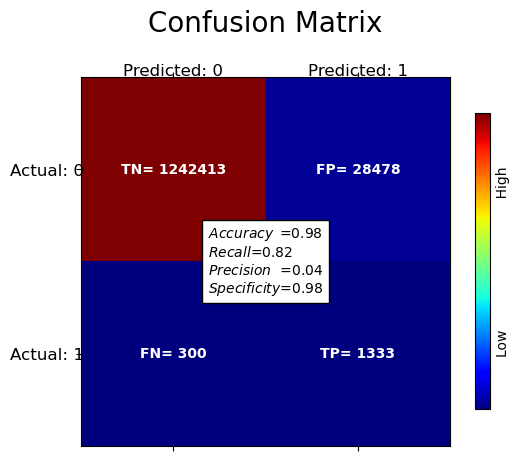

In [18]:
ax1 = plt.axes()
im =ax1.matshow(conf_mx, cmap='jet', interpolation='nearest')
label = ['0','1']
x=[f'Predicted: {label[0]}', f'Predicted: {label[1]}']; y=[f'Actual: {label[0]}', f'Actual: {label[1]}']
ii=0
for (i, j), z in np.ndenumerate(conf_mx):
            if(ii==0): al='TN= '
            if(ii==1): al='FP= '
            if(ii==2): al='FN= '
            if(ii==3): al='TP= '

            ax1.text(j, i, al+'{:0.0f}'.format(z), color='w', ha='center', va='center', fontweight='bold',fontsize=10)
            ii=ii+1

txt='$ Accuracy\,\,\,$=%.2f\n$Recall$=%.2f\n$Precision\,\,\,\,$=%.2f\n$Specificity$=%.2f'
anchored_text = AnchoredText(txt %(acr,reca,prec,spec), loc=10, borderpad=0)
ax1.add_artist(anchored_text)

ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x, fontsize=12,y=0.97, rotation='horizontal')

ax1.set_yticks(np.arange(len(y)))
ax1.set_yticklabels(y, fontsize=12,x=0.035, rotation='horizontal')

cbar =plt.colorbar(im,shrink=0.8,
                           label='Low                              High',orientation='vertical')
cbar.set_ticks([])
ax1.grid(visible=False )
plt.title('Confusion Matrix',fontsize=20,y=1.1)


Although the AUPRC is relatively high at, at 0.43, and the recall for the model is also quite high at 0.82, there are a large number of False Positives being identified.  

The precision indicates that 5% of predicted fraudulent transactions were actually fraudulent, thus the potential client impact could be substantial when implemented.


## Extract feature importances  
Shapely values are used to evaluate the feature importance

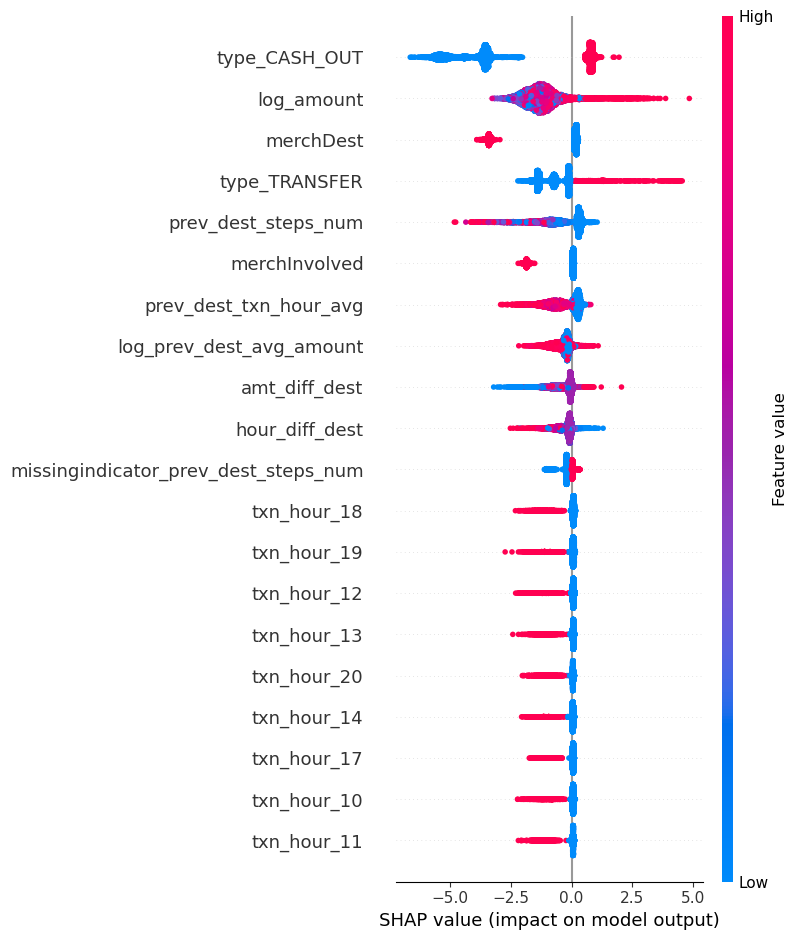

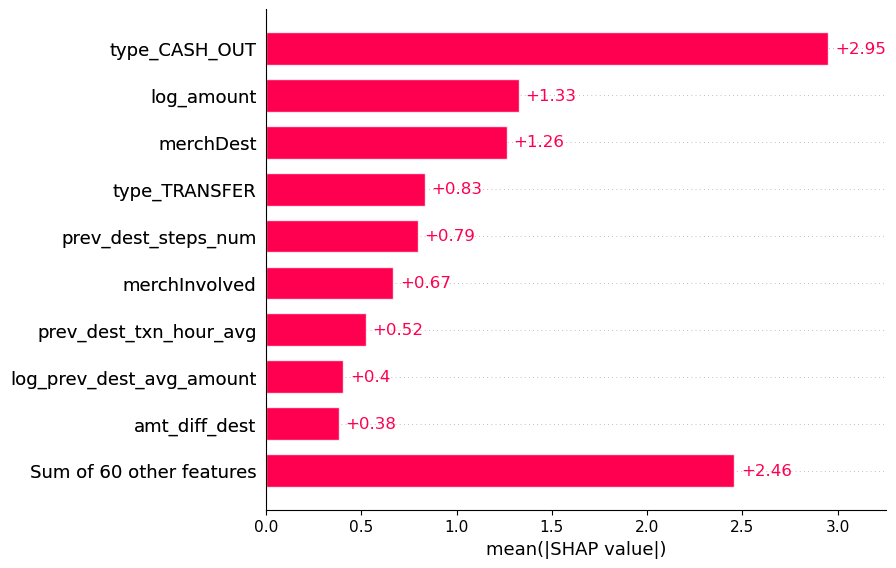

In [19]:
Classification_eval.plot_shap_summary_and_importance(random_search_fit.best_estimator_,
                                 test[all_columns_fit],
                                 max_display=20, random_state=seed)

The Top 5 Features the model has considered as important are:

* **type_CASH_OUT** : Whether the transaction was a CASH OUT type
* **merchDest** : Whether or not a merchant was the destination of the transaction
* **log_amount** : The log of the value of the transaction
* **type_TRANSFER** : Whether the transaction was a TRANSFER
* **prev_dest_steps_num** : How many transactions have been made to the destination account previously




Plotting the features not previously plotted will allow exploration of their relationship to the target feature.  Note that transformed versions of some features are plotted to aid in interprtability, especially for amount fetures.

In [20]:
dfp_fraud    = test[test['isFraud'] == 1]
dfp_nonfraud = test[test['isFraud'] == 0]

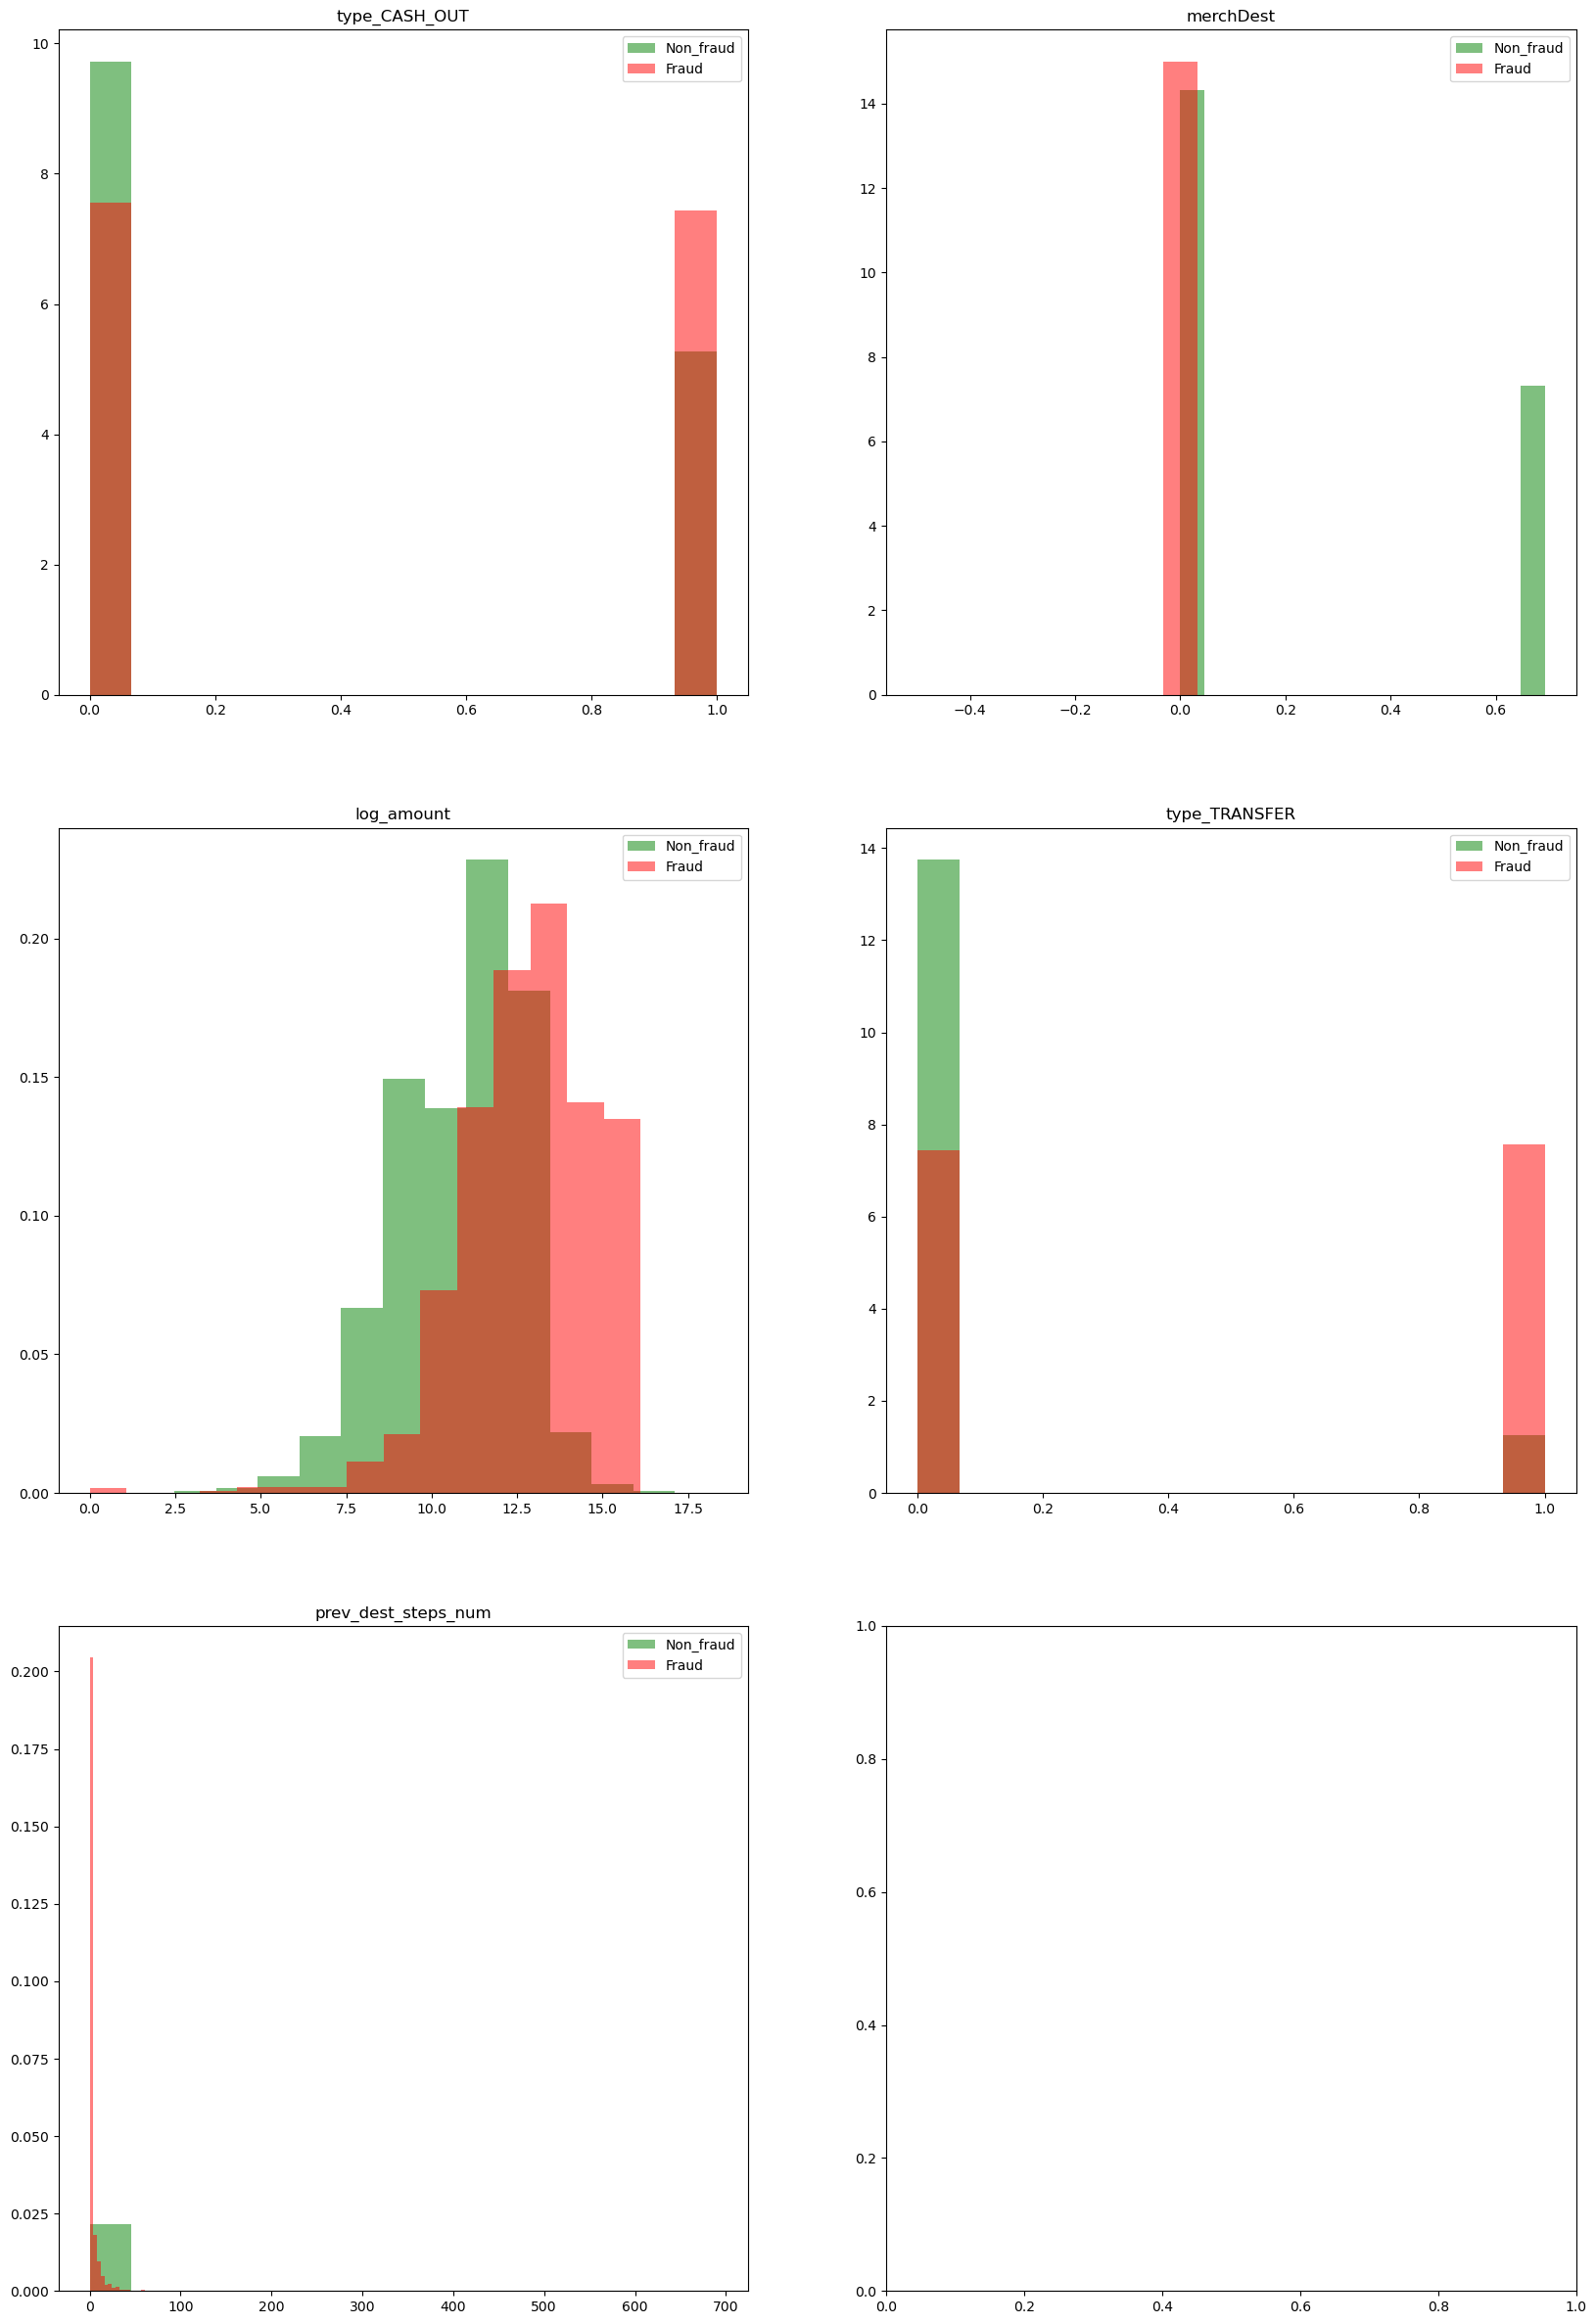

In [21]:
bins=15
fig, axs = plt.subplots(3,2,figsize=(20, 30), sharey = False)

axs[0, 0].hist((dfp_nonfraud['type_CASH_OUT'] ), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[0, 0].hist((dfp_fraud['type_CASH_OUT'] ), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[0, 0].set_title('type_CASH_OUT')
axs[0, 0].legend()

axs[0, 1].hist((dfp_nonfraud['merchDest'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[0, 1].hist((dfp_fraud['merchDest'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[0, 1].set_title('merchDest')
axs[0, 1].legend()

axs[1, 0].hist((dfp_nonfraud['log_amount'] ), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[1, 0].hist((dfp_fraud['log_amount'] ), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[1, 0].set_title('log_amount')
axs[1, 0].legend()

axs[1, 1].hist((dfp_nonfraud['type_TRANSFER'] ), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[1, 1].hist((dfp_fraud['type_TRANSFER'] ), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[1, 1].set_title('type_TRANSFER')
axs[1, 1].legend()

axs[2, 0].hist((dfp_nonfraud['prev_dest_steps_num'] ), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[2, 0].hist((dfp_fraud['prev_dest_steps_num'] ), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[2, 0].set_title('prev_dest_steps_num')
axs[2, 0].legend()


Interpretation of Top 5 most important features:  

* **type_CASH_OUT** : CASH_OUT transactions had higher rates of fraud compared to when the transaction was not a CASH_OUT
* **merchDest** : A Merchant was never involved in a fraudulent transaction
* **log_amount** : The distribution of the fraudulent transactions indicate that they tend to have higher average transaction amounts.
* **type_TRANSFER** : TRANSFER transactions had a significantly higher rate of fraud compared to when the transaction was not a TRANSFER
* **prev_dest_steps_num** : Fraudulent destination accounts tend not to have previous transactions, however when they do, their previous transactions tend to happen earlier in the morning.

In [ ]:
# Release memory of pandas datasets
del(dfp_nonfraud)
del(dfp_fraud)


NameError: name 'dfp_nonfraud' is not defined

In [24]:
os.makedirs('models', exist_ok=True)
 
with open('models/paysim_model.pkl', 'wb') as f:
    pickle.dump(random_search_fit, f)
 
print("Model trained and saved successfully!")

Model trained and saved successfully!




---



---



# **Tuning Model Threshold**

## Precision / Recall

Considering the current precision of the model, I would also like to investigate whether there might be other prediction thresholds (vs the current 0.5), that might have a better tradeoff when it comes to precision and recall.  
  
For this, we plot and examine the precision and recall compared to the various thresholds of the model.

In [ ]:
# Define a hhelper function to plot the precision and recall vs threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, x=0.8):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "y-", label="Sensitivity", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Precision/Sensitivity", fontsize=12)
    plt.title("Precision and Sensitivity versus Threshold", fontsize=12)
    plt.grid(linewidth='0.25')
    plt.axvline(x=x,linestyle='--',color='k',label='Probability: '+str(np.round(x,2)))
    plt.legend(loc=3, ncol=3,fontsize=10,markerscale=1.2, edgecolor="black",framealpha=0.9)
    plt.axis([0, 1, 0, 1])

In [ ]:
# obtain the precision, sensitivity and threshold
precisions, sensitivity, thresholds = precision_recall_curve(test['isFraud'], random_search_fit.predict_proba (test[all_columns_fit])[:,1] )

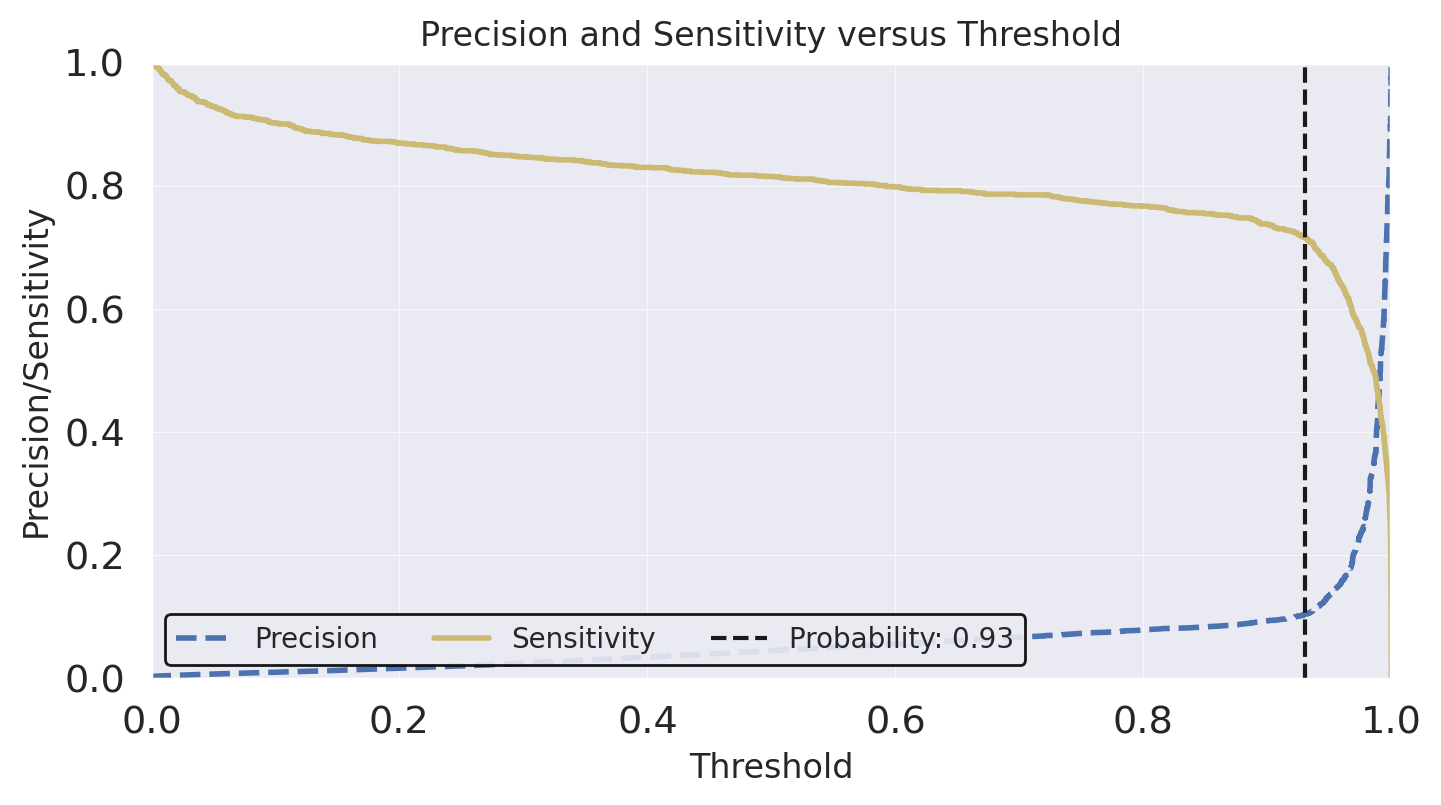

In [ ]:
font = {'size' : 10}
plt.rc('font', **font)
fig = plt.subplots(figsize=(8,4), dpi= 200, facecolor='w', edgecolor='k')

plot_precision_recall_vs_threshold(precisions, sensitivity, thresholds, x=0.93)
plt.show()

The threshold of 0.93 was selected as an inflection point, as that is the point where the Precision reached 10%.  

The performance of this new cutoff is tested next.

In [ ]:
test_thresh = pd.concat([test['isFraud'], pd.Series(random_search_fit.predict_proba(test[all_columns_fit])[:,1])], axis=1)
test_thresh.columns = ['isFraud', 'prob']
test_thresh.head()

,isFraud,prob
0,0,0.00
1,0,0.97
2,0,0.00
3,0,0.00
4,0,0.00


In [ ]:
test_thresh['prediction'] = test_thresh['prob'].apply(lambda x: 1 if x > 0.93 else 0)
test_thresh.head()

,isFraud,prob,prediction
0,0,0.00,0
1,0,0.97,1
2,0,0.00,0
3,0,0.00,0
4,0,0.00,0


In [ ]:
conf_mx_thresh = confusion_matrix(test_thresh['isFraud'],test_thresh['prediction'] )
print(conf_mx_thresh)

[[1260833   10058]
 [    464    1169]]


In [ ]:
TP = conf_mx_thresh[1][1]
TN = conf_mx_thresh[0][0]
FP = conf_mx_thresh[0][1]
FN = conf_mx_thresh[1][0]

spec= TN/(TN+FP)
reca = TP/(TP+FN)
prec = TP/(TP+FP)
acr = (TP+TN)/(TP+TN+FP+FN)

Text(0.5, 1.1, 'Confusion Matrix @ 0.93')

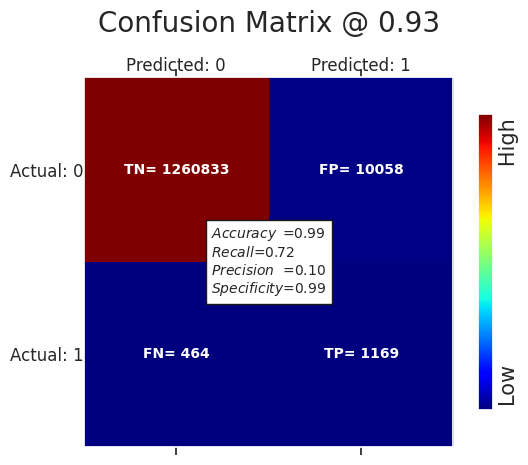

In [ ]:
ax1 = plt.axes()
im =ax1.matshow(conf_mx_thresh, cmap='jet', interpolation='nearest')
label = ['0','1']
x=[f'Predicted: {label[0]}', f'Predicted: {label[1]}']; y=[f'Actual: {label[0]}', f'Actual: {label[1]}']
ii=0
for (i, j), z in np.ndenumerate(conf_mx_thresh):
            if(ii==0): al='TN= '
            if(ii==1): al='FP= '
            if(ii==2): al='FN= '
            if(ii==3): al='TP= '

            ax1.text(j, i, al+'{:0.0f}'.format(z), color='w', ha='center', va='center', fontweight='bold',fontsize=10)
            ii=ii+1

txt='$ Accuracy\,\,\,$=%.2f\n$Recall$=%.2f\n$Precision\,\,\,\,$=%.2f\n$Specificity$=%.2f'
anchored_text = AnchoredText(txt %(acr,reca,prec,spec), loc=10, borderpad=0)
ax1.add_artist(anchored_text)

ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x, fontsize=12,y=0.97, rotation='horizontal')

ax1.set_yticks(np.arange(len(y)))
ax1.set_yticklabels(y, fontsize=12,x=0.035, rotation='horizontal')

cbar =plt.colorbar(im,shrink=0.8,
                           label='Low                              High',orientation='vertical')
cbar.set_ticks([])
ax1.grid(visible=False )
plt.title('Confusion Matrix @ 0.93',fontsize=20,y=1.1)


The adjustment of the threshold from 0.5 to 0.93, allows the number of false positives to reduce substantially from \~28 000 to \~10 000 (~33% decrease), while allowing the false negatives to increase from 302 to 464 (a ~50% increase).  
  
This would mean a decrease in operational costs of investigating False postives, or inconveniencing clients based on Falsly flagging the transaction as fraud, however fraud losses will increase when using this method as is.  

A better method would be to quantify the impact of each false positive and each false negative, to determine which threshold to use.

## Cost of decisions

The cost of making a wrong prediction is not the same in each scenario.  Consider the following:  



*   Predicting a transaction as fraudulent, when it is not (False Positive):  
    There are costs involved in investigating the transaction and potentially liasing with a client for a period of time.  Clients might still transact with the company and could consider this as protection of their funds.
      
*   Predicting a transaction as NOT fraudulent, when it is (False Negative):
    Costs of absorbing the cost of the transaction on behalf of the client, cost of investigating the transaction, loss of reputation/trust as transactions cannot be trusted as a whole.  This could lead to loss of a client as a whole, with no future transactions happening.

These costs are clearly not the same, as one could lead to client loss.  False positives could be managed in the general operational workflow, with confirmation being requested from the client digitally once flagged.  This would also allow the capture of the true fraudulent events ocurring.


In the absence of true cost availability for each decision, a good approximation would be to use the median transaction amount (179 861) as a cost metric, since the amount may need to be absorbed entirely in the event of a false negative, in an effort to maintain the relationship with a client.  Also note that the average a

Thus, assume the following costs are associated with each decision:  



*   False Positive:  
    25% of the median transaction amount, to account for operational costs of potentially up with a client:   **18 716**
*   False Negative:
    250% of the median transaction amount, to account for absorbing of the full transaction amount, potential loss of reputation and investigation costs:  **187 160**
*   True Positive:
    Negative of the median transaction amount, as it would account for the capture of the actual fraudulent cases that actually DECREASE costs:  **-74 864**
*   True Negative:  
    No cost is assigned to the True negatives, as there should be no more costs assigned based on the decision, if no benefit or cost arises:  **No cost**

In an ideal scenario, having profit assigned to each decision (even where no costs were involved), would yield the best results, as currently, having no cost to True negatives would mean we minimise the cost by just classifying everything as as Negative (threshold of 1).  However in this scenario we assume that as not being possible.


This approximation leads to the following total costs:  
  
  
*Total Cost = (FP * cost of FP) + (FN * cost of FN) + (TP * cost of TP) + (TN * cost of TN)*




*   0.5 Threshold:  

    28 030 * 18 716 + 302 * 187 160 + ( 331 * -74 864) + 0 = **556 351 816**
*   0.93 Threshold:  

    10 058 * 18 716 + 464 * 187 160 + (1 169 * -74 864) + 0 = **187 571 752**  


The change of the threshold also reduced the estimated costs substantially, even though more False Negatives were flagged. Ideally, plotting this figure across a range of thresholds would be the best solution, thereby deciding where costs would be minimised (or profit maximised).
